# Plot track intensity over time 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os
sys.path.append('../src/')
from intensity_time_plots import filter_track_ids_by_length_ranges, random_track_ids
from intensity_time_plots import intensity_time_plot, createBufferForLifetimeCohort
from intensity_time_plots import createBufferForLifetimeCohort_normalized, cumulative_plots

In [22]:
###### Set the following variables #######


# Background intensity for each channel

background_channel_1 = 240
background_channel_2 = 150
background_channel_3 = 170

# framerate (in milliseconds)

framerate_msec = 2500

# protein names (optional)

channel1_name = 'Arp2/3-Halo'
channel2_name = 'Dynamin2-tagGFP2'
channel3_name = 'AP2-tagRFPt'

### Which type of intensity to report per spot
Options:
* voxel_sum_adjusted (default): background-subtracted sum intensity
* voxel_sum: sum intensity
* peak_mean: mean intensity
* peak_max: max intensity


In [23]:
value_to_plot = 'voxel_sum_adjusted'
# value_to_plot = 'voxel_sum'
# value_to_plot = 'peak_mean'
# value_to_plot = 'peak_max'

if value_to_plot == 'voxel_sum_adjusted':
    background_channel_1 = 0
    background_channel_2 = 0
    background_channel_3 = 0

# use this list to see all possible values to plot
# track_df.columns

In [24]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'track_df_cleaned_final_full.pkl'
input_directory_all_tracks_full = os.path.join(base_dir,input_directory, input_file_name)

input_file_name = 'filtered_tracks_final.pkl'
input_directory_full_filtered_tracks = os.path.join(base_dir,input_directory , input_file_name)

In [25]:
track_df = pd.read_pickle(input_directory_all_tracks_full)
filtered_tracks = pd.read_pickle(input_directory_full_filtered_tracks)

Set which region to plot. Default is 'All'

In [26]:
# region_to_plot = 'Apical'
# region_to_plot = 'Lateral'
# region_to_plot = 'Basal'
region_to_plot = 'All'

if region_to_plot != 'All':
    filtered_tracks_all = filtered_tracks
    filtered_tracks = filtered_tracks_all[filtered_tracks_all['membrane_region'] == region_to_plot]

print('You are about to plot the following region: ', region_to_plot)


You are about to plot the following region:  All


Define cohort sizes

In [27]:
# range of track lengths to plot in each cohort, in frames
custom_length_ranges = [[5, 10], [11,15], [16, 20], [21, 25], [26, 30], [31, 40], [41,90]]

## Pick which channel(s) to plot

In [28]:
# by default you always plot channel 3 positive (fixing this)

# e.g. [True, True] to plot all three channels
# or [True, False] to plot channels 1 and 2

channels_to_plot = [True, True]

tracks_channel_subset = filtered_tracks[(filtered_tracks['channel1_positive'] == channels_to_plot[0]) &
                                 (filtered_tracks['channel2_positive'] == channels_to_plot[1])]

# will get this to work:

# e.g. [True, True, True] to plot all three channels
# or [True, False, True] to plot channels 1 and 3

# channels_to_plot = [True, True, True]

# tracks_channel_subset = filtered_tracks[(filtered_tracks['channel1_positive'] == channels_to_plot[0]) &
#                                  (filtered_tracks['channel2_positive'] == channels_to_plot[1]) &
#                                  (filtered_tracks['channel3_positive'] == channels_to_plot[2])]

# tracks_channel_subset.head()

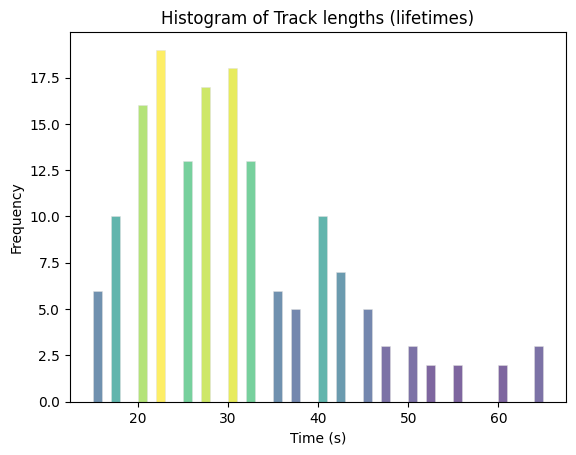

In [29]:
# Plot histogram of all track lengths (lifetimes)

# 'all lifetimes' is a variable of all the track lengths, multipilied by time per track

all_lifetimes =  tracks_channel_subset['track_length']*framerate_msec/1000

n, bins, patches = plt.hist(all_lifetimes, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int')

# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.hist(all_lifetimes, bins=50, edgecolor=black)
plt.xlabel('Time (s)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Histogram of Track lengths (lifetimes)')  # Title of the histogram
plt.show()

In [30]:
track_id_arrays = filter_track_ids_by_length_ranges(dataframe = tracks_channel_subset, track_length_buckets = custom_length_ranges, 
                                 track_id_col_name = 'track_id', track_length_col_name = 'track_length')

print(f'number of tracks between [5,10] frames long are {len(track_id_arrays[0])}')
print(f'number of tracks between [11,15] frames long are {len(track_id_arrays[1])}')
print(f'number of tracks between [16,20] frames long are {len(track_id_arrays[2])}')
print(f'number of tracks between [21,25] frames long are {len(track_id_arrays[3])}')
print(f'number of tracks between [26,30] frames long are {len(track_id_arrays[4])}')
print(f'number of tracks between [31,40] frames long are {len(track_id_arrays[5])}')
print(f'number of tracks between [41,90] frames long are {len(track_id_arrays[6])}')

number of tracks between [5,10] frames long are 64
number of tracks between [11,15] frames long are 59
number of tracks between [16,20] frames long are 28
number of tracks between [21,25] frames long are 6
number of tracks between [26,30] frames long are 3
number of tracks between [31,40] frames long are 0
number of tracks between [41,90] frames long are 0


In [31]:
# Statistics of track lengths for each condition

Plot random tracks

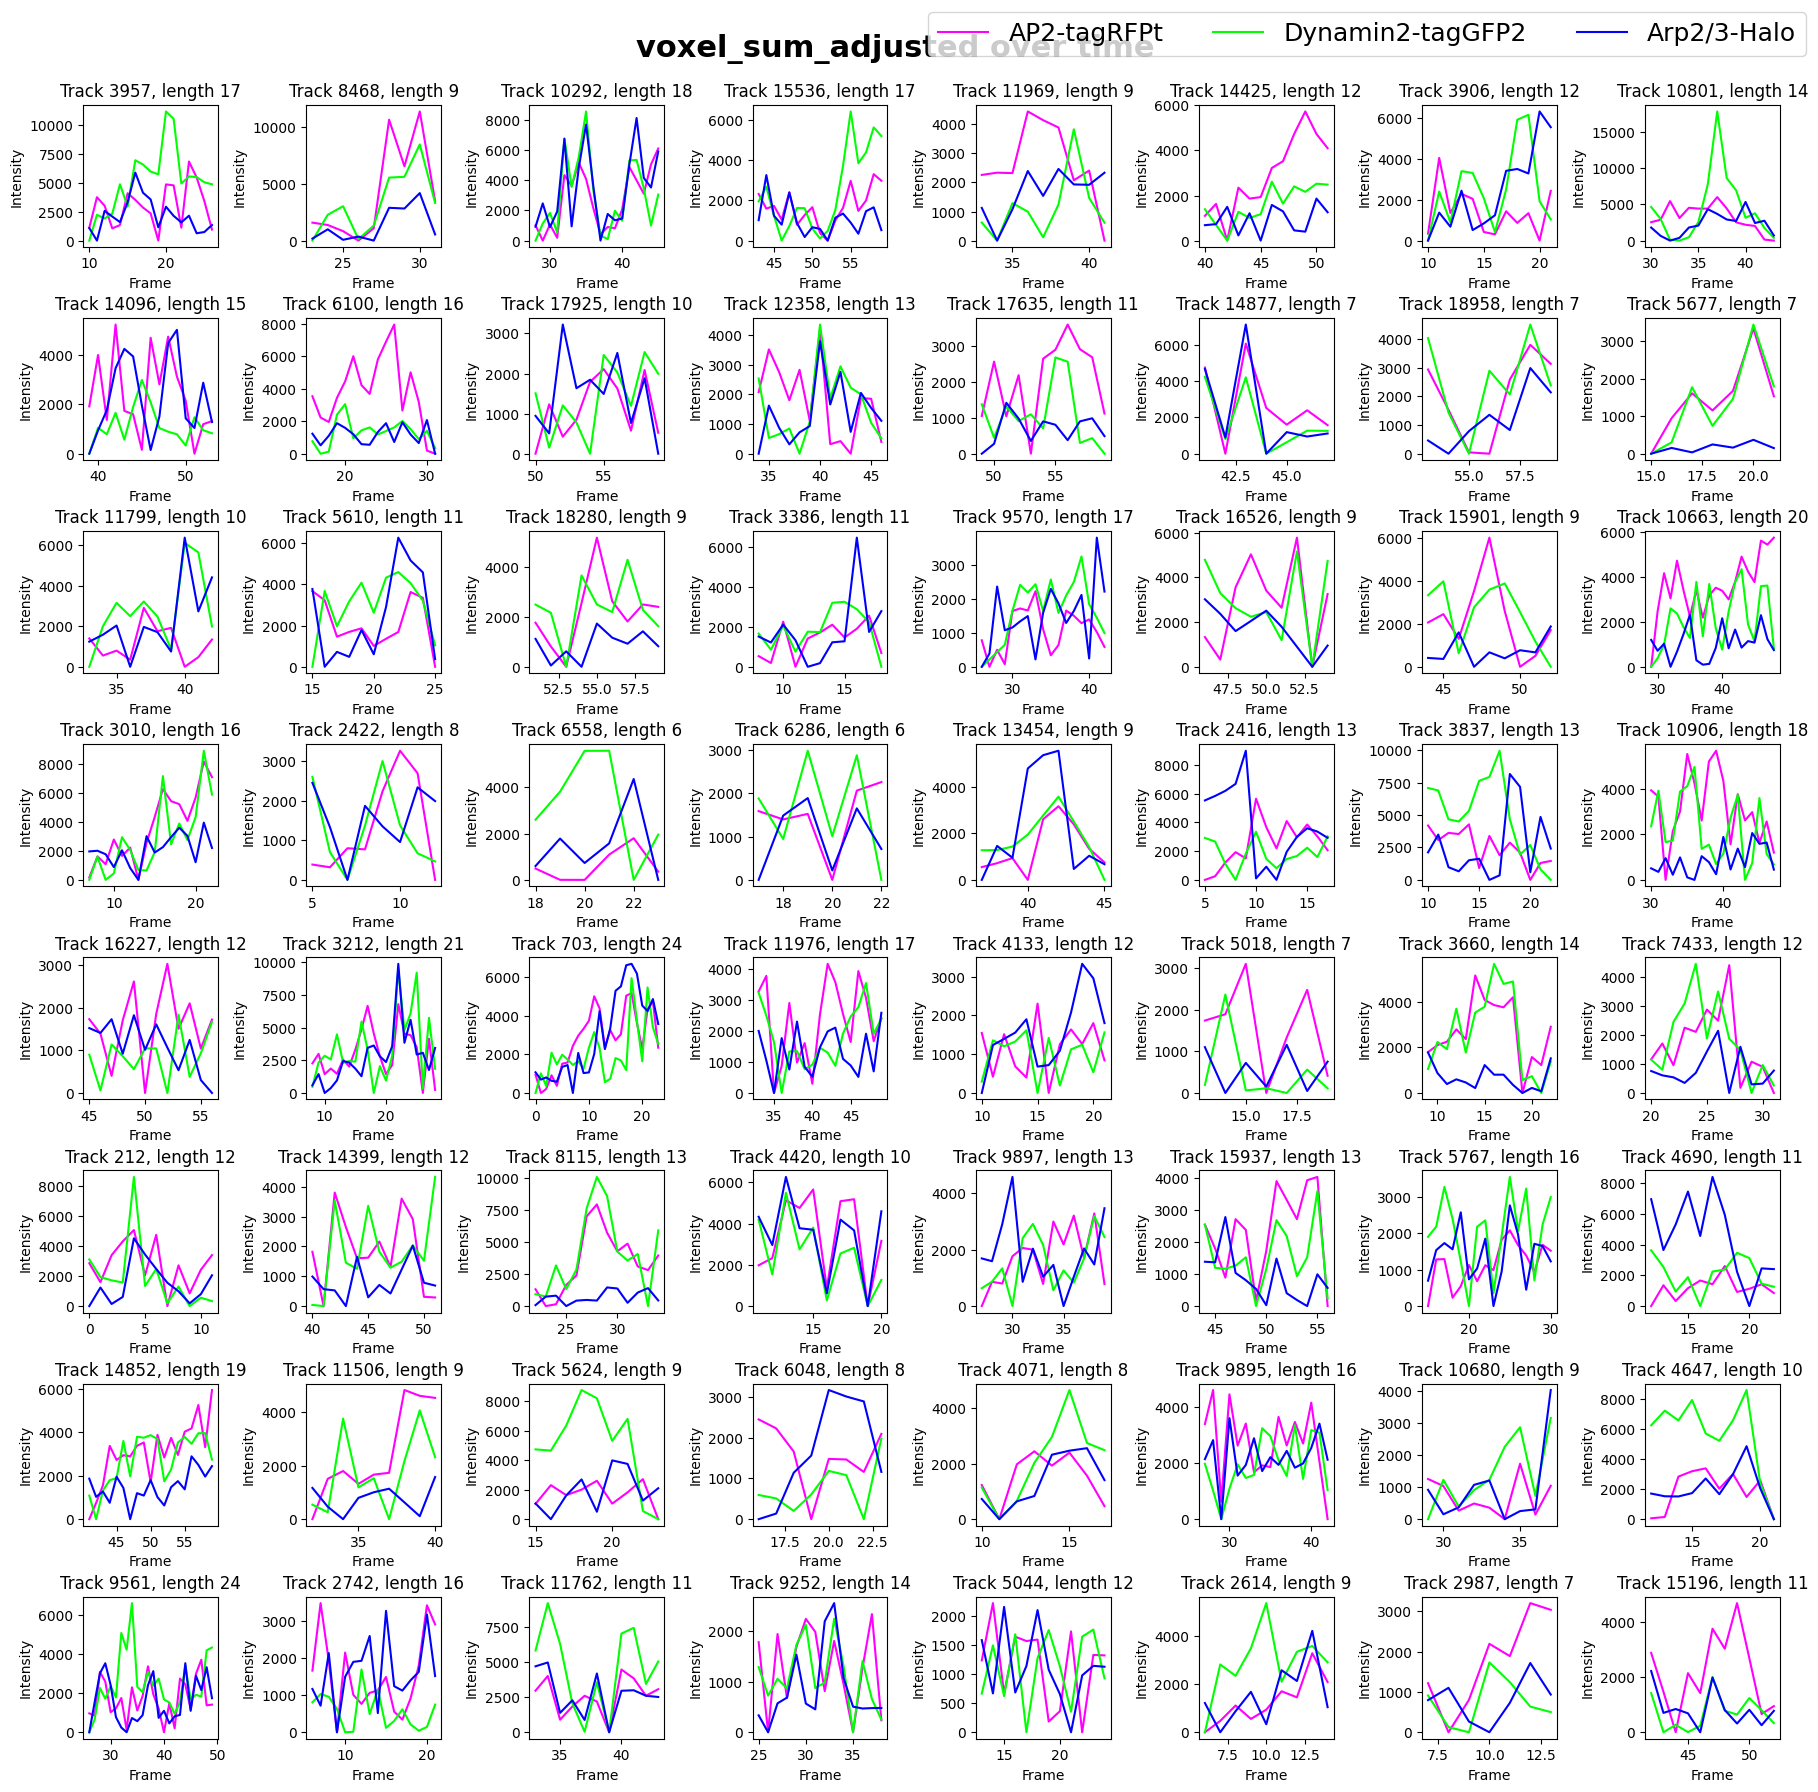

In [32]:
# set 'normalized = False' to plot raw intensities

random_tracks = random_track_ids(dataframe = tracks_channel_subset, desired_length = [0, np.inf], 
                                 track_length_col_name = 'track_length', track_id_col_name = 'track_id', 
                                num_to_select = 64)

intensity_time_plot(dataframe = track_df, tracks_to_plot = random_tracks, 
intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id', 
frame_col_name = 'frame', channels_to_plot = 3, legend_values = [channel3_name, channel2_name, channel1_name],
line_colors = ['magenta', 'lime', 'blue'], graph_title = f'{value_to_plot}', normalized=False)

In [33]:
# Uncomment to plot random tracks from a specific lifetime cohort
# ## Pick which lifetime cohort to plot from, between 0 (shortest tracks) to 6 (longest tracks)

# cohort_to_plot = 3

# print("plotting tracks between " + str(custom_length_ranges[3][0]) + " and " + str(custom_length_ranges[3][1]) + " frames long")

# ### Select random track ids of a desired length 

# random_tracks = random_track_ids(dataframe = channel_subset, desired_length = custom_length_ranges[cohort_to_plot], 
#                                  track_length_col_name = 'track_length', track_id_col_name = 'track_id', 
#                                 num_to_select = 64)

# ### The amplitude used for plotting is voxel sum from both channels. Minimum voxel sum is subtracted from all values to try and bring starting intensities close to zero

# intensity_time_plot(dataframe = track_df, tracks_to_plot = random_tracks, 
# intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id', 
# frame_col_name = 'frame', channels_to_plot = 3, legend_values = ['Channel 3', 'Channel 2', 'Channel 1'],
# line_colors = ['magenta', 'lime', 'blue'], graph_title = f'{value_to_plot}')

In [34]:
# primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort(dataframe = track_df ,
# listOfTrackIdsAssignedToCohort = track_id_arrays[2], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1], 
# intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')

# # visualize alignment of tracks

# plt.figure(dpi=300)
# plt.title(channel3_name)
# plt.imshow(primary_buffer)

# plt.figure(dpi=300)
# plt.title(channel2_name)
# plt.imshow(secondary_buffer)

# plt.figure(dpi=300)
# plt.title(channel1_name)
# plt.imshow(tertiary_buffer)


## Intensity plots by lifetime cohort

/Users/matsulab/Desktop/LLSM-CME-ANALYSIS/Final/Jupyter_Notebooks/../src/intensity_time_plots.py:356: RuntimeWarning: Mean of empty slice
  buffer_average = np.nanmean(buffer, axis=0) - background_intensity[i]
/Users/matsulab/miniconda3/envs/cme_pipeline/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


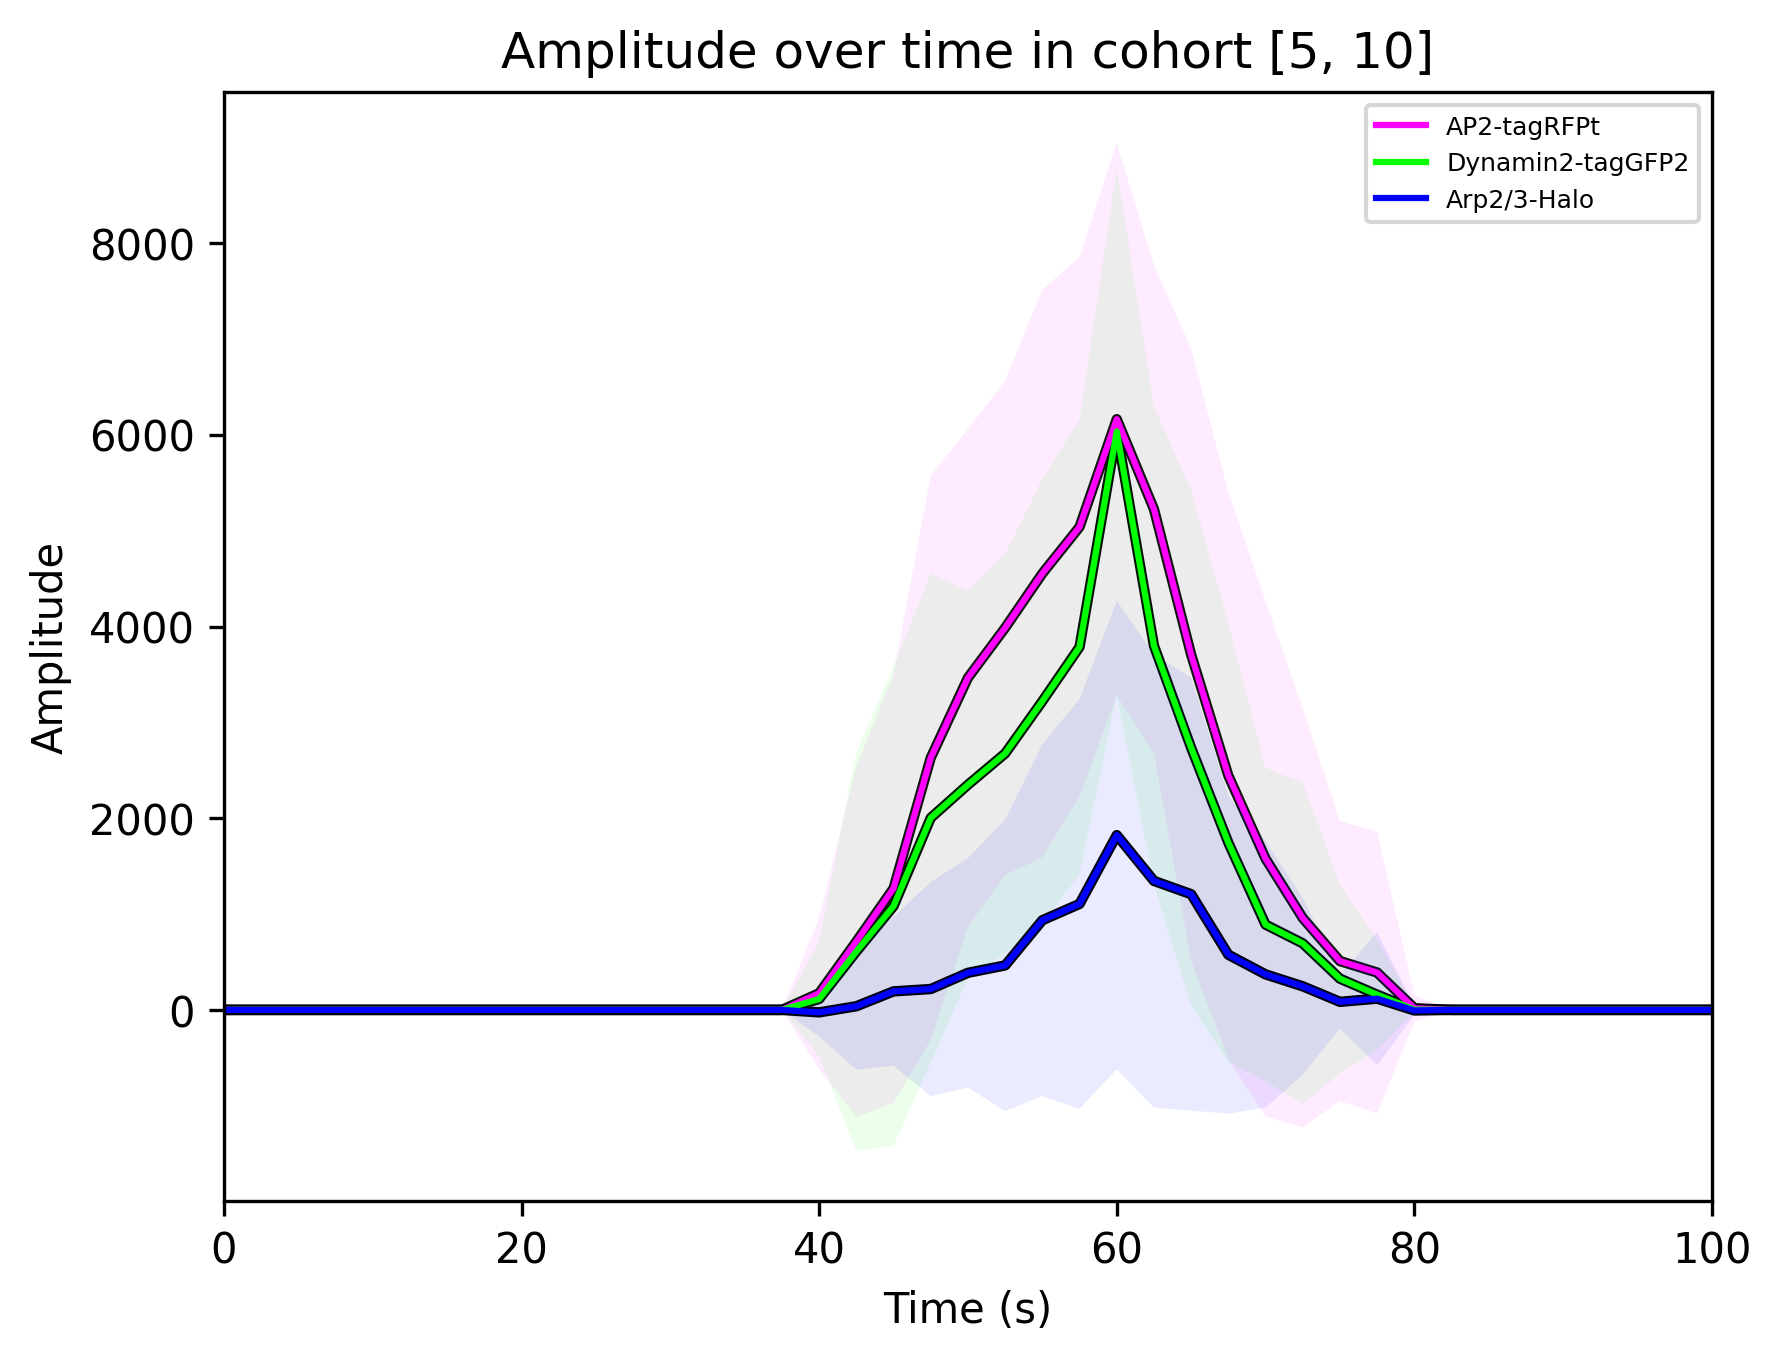

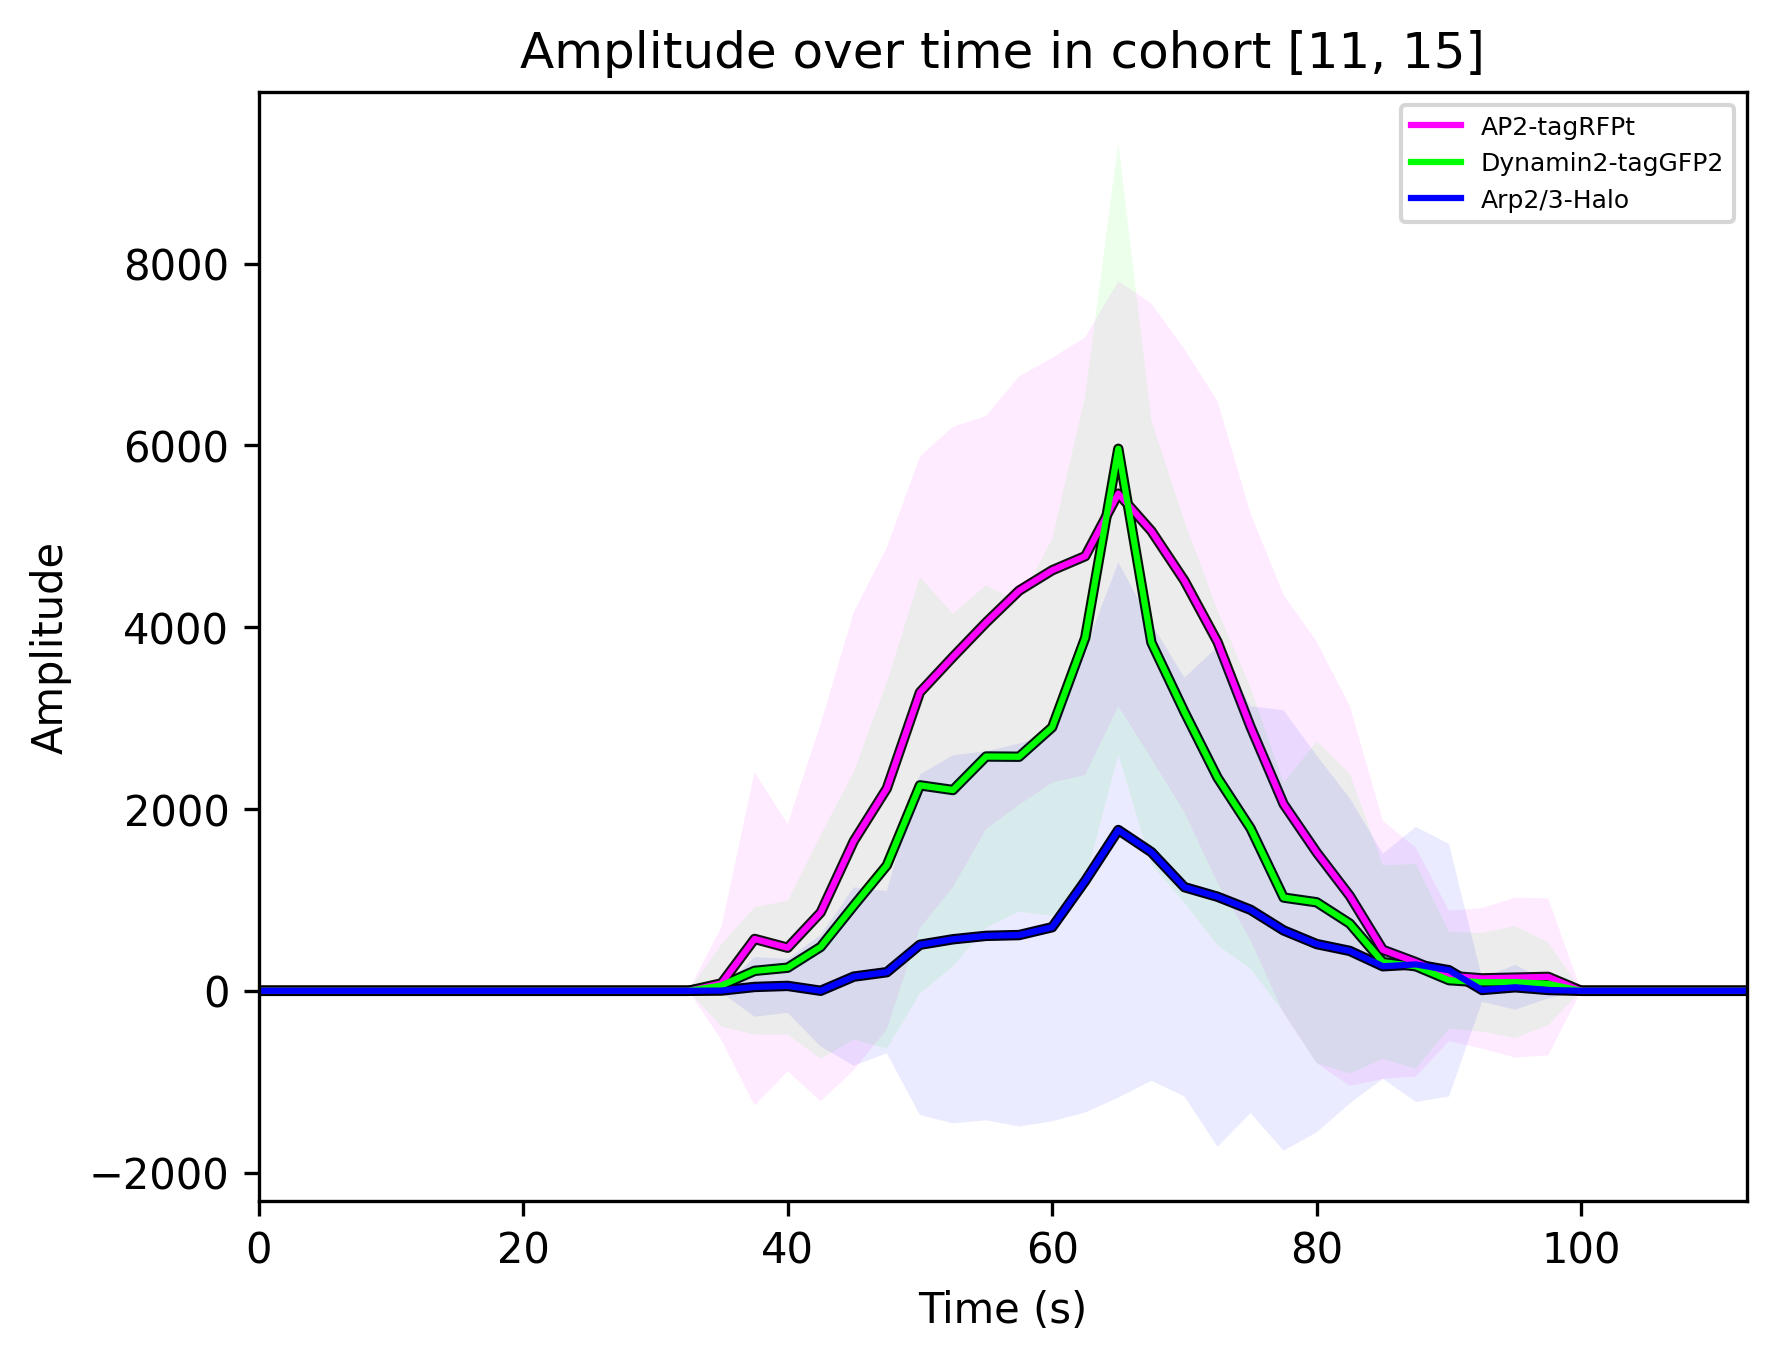

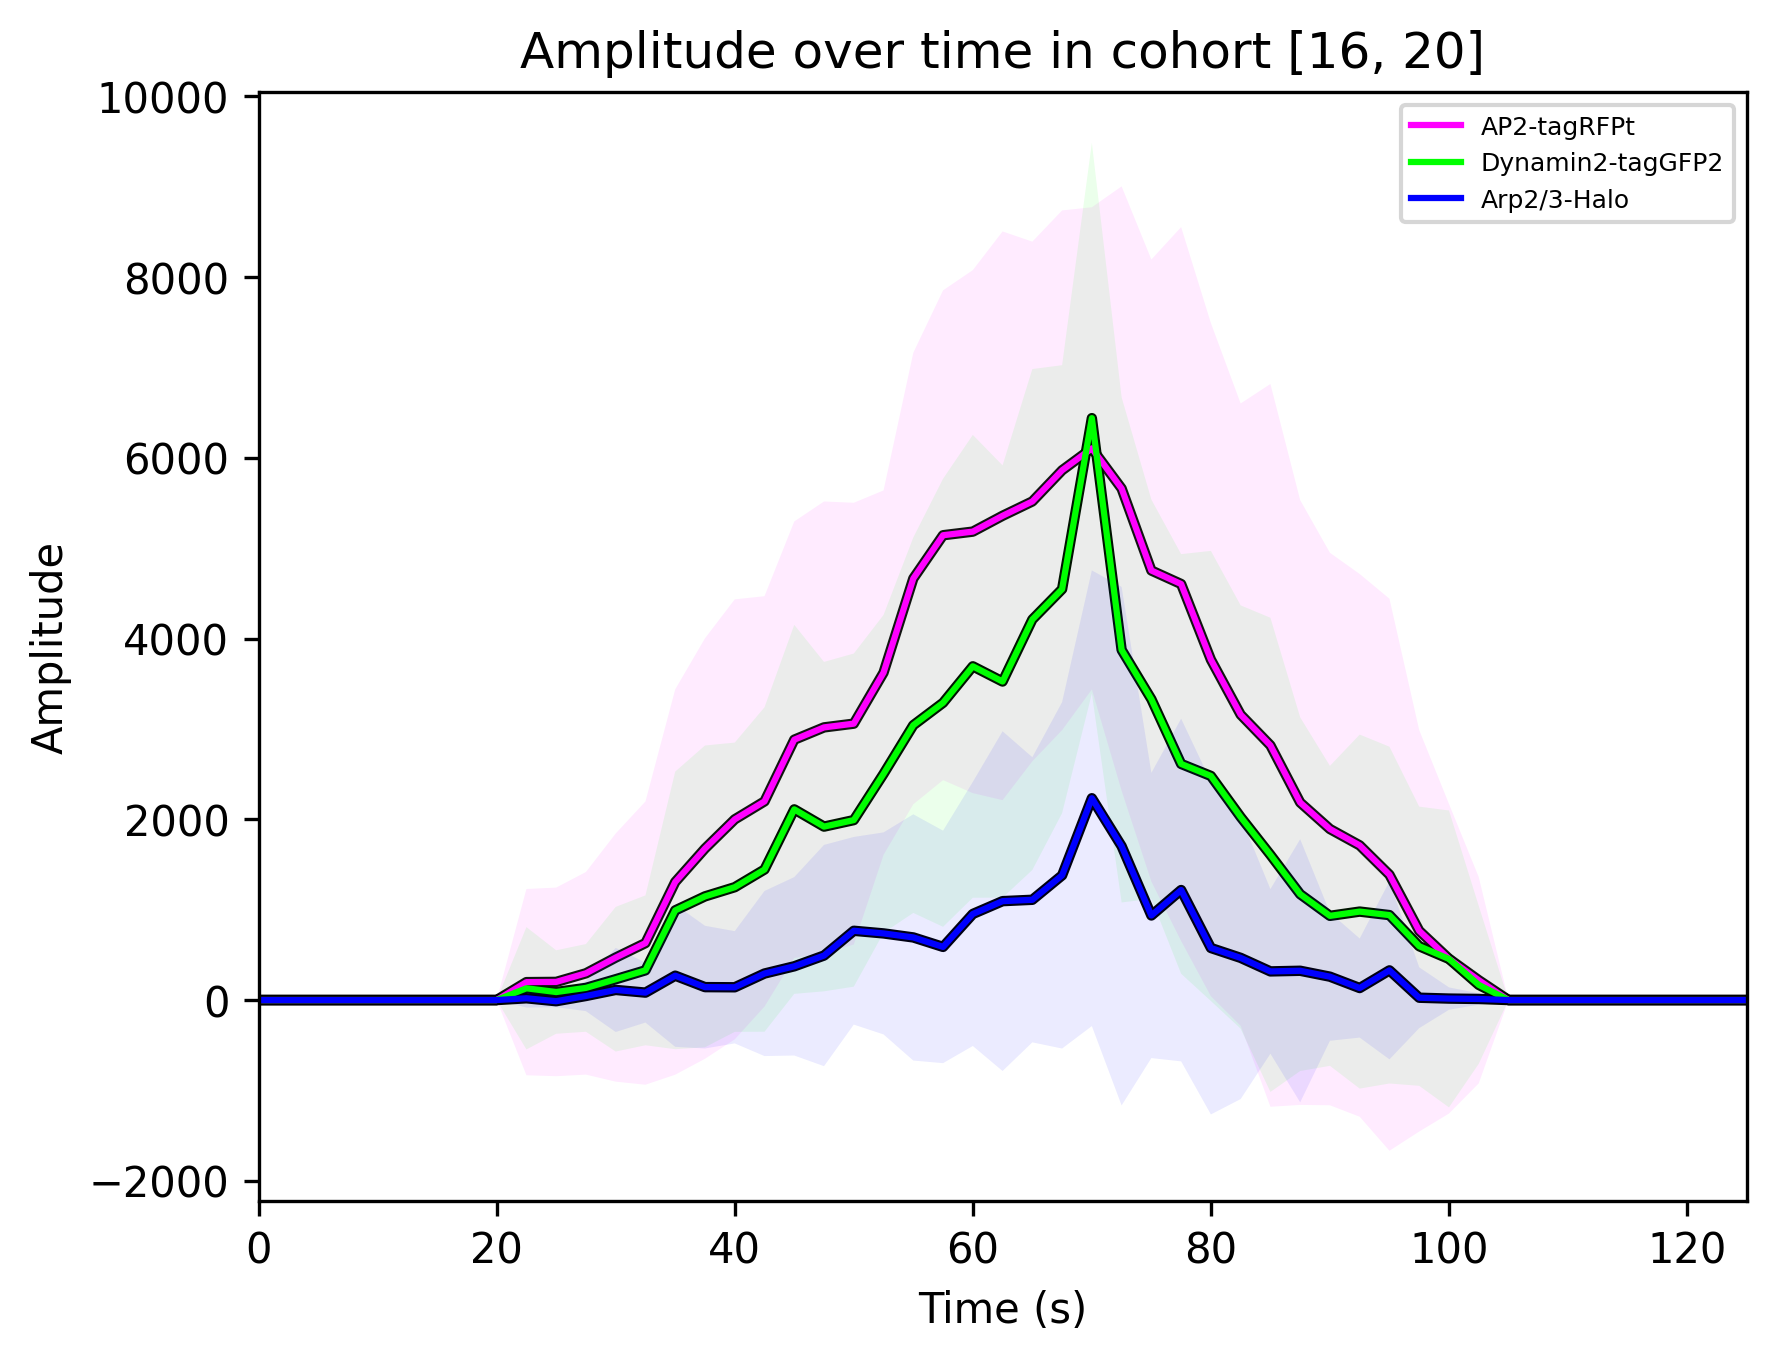

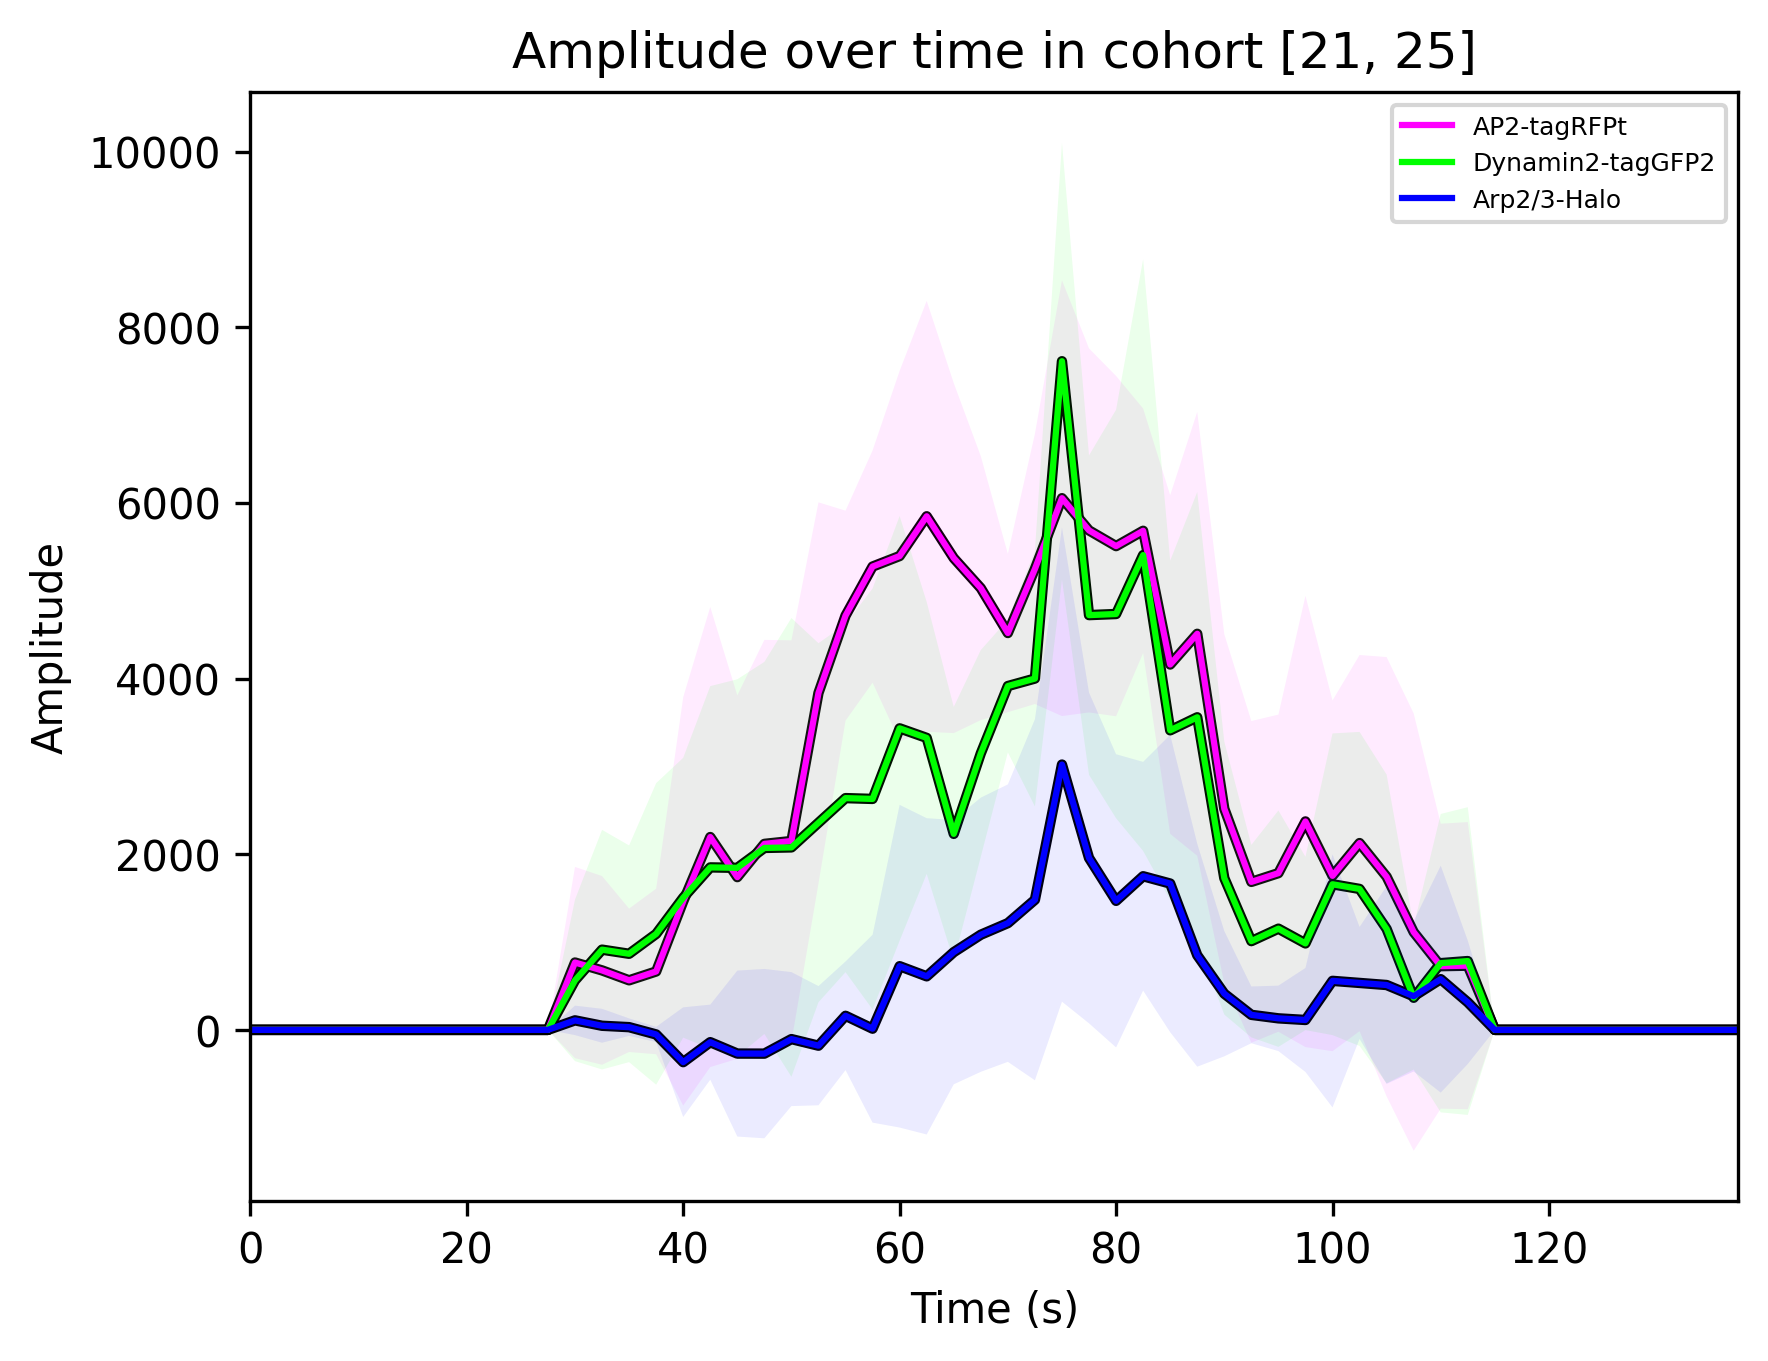

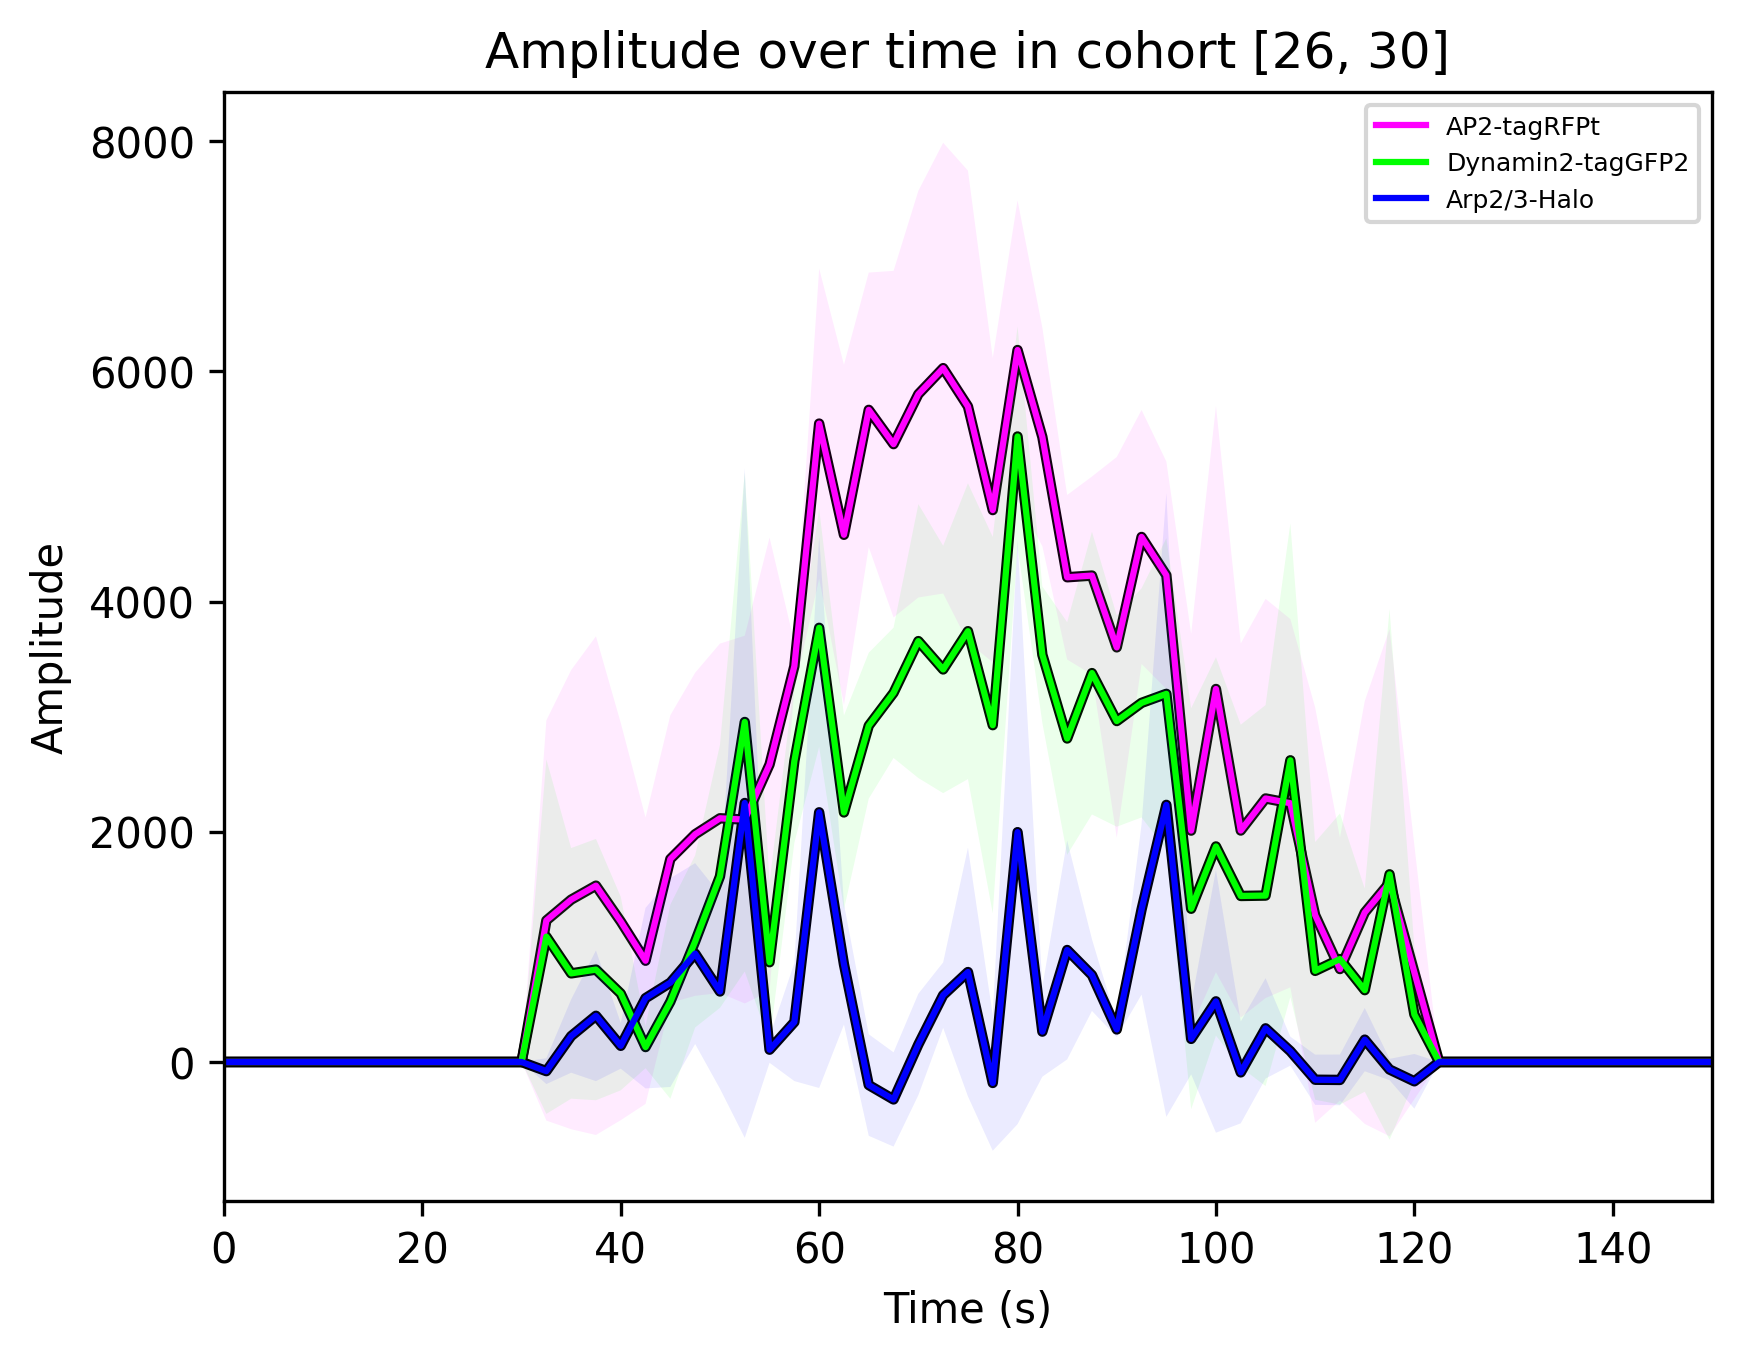

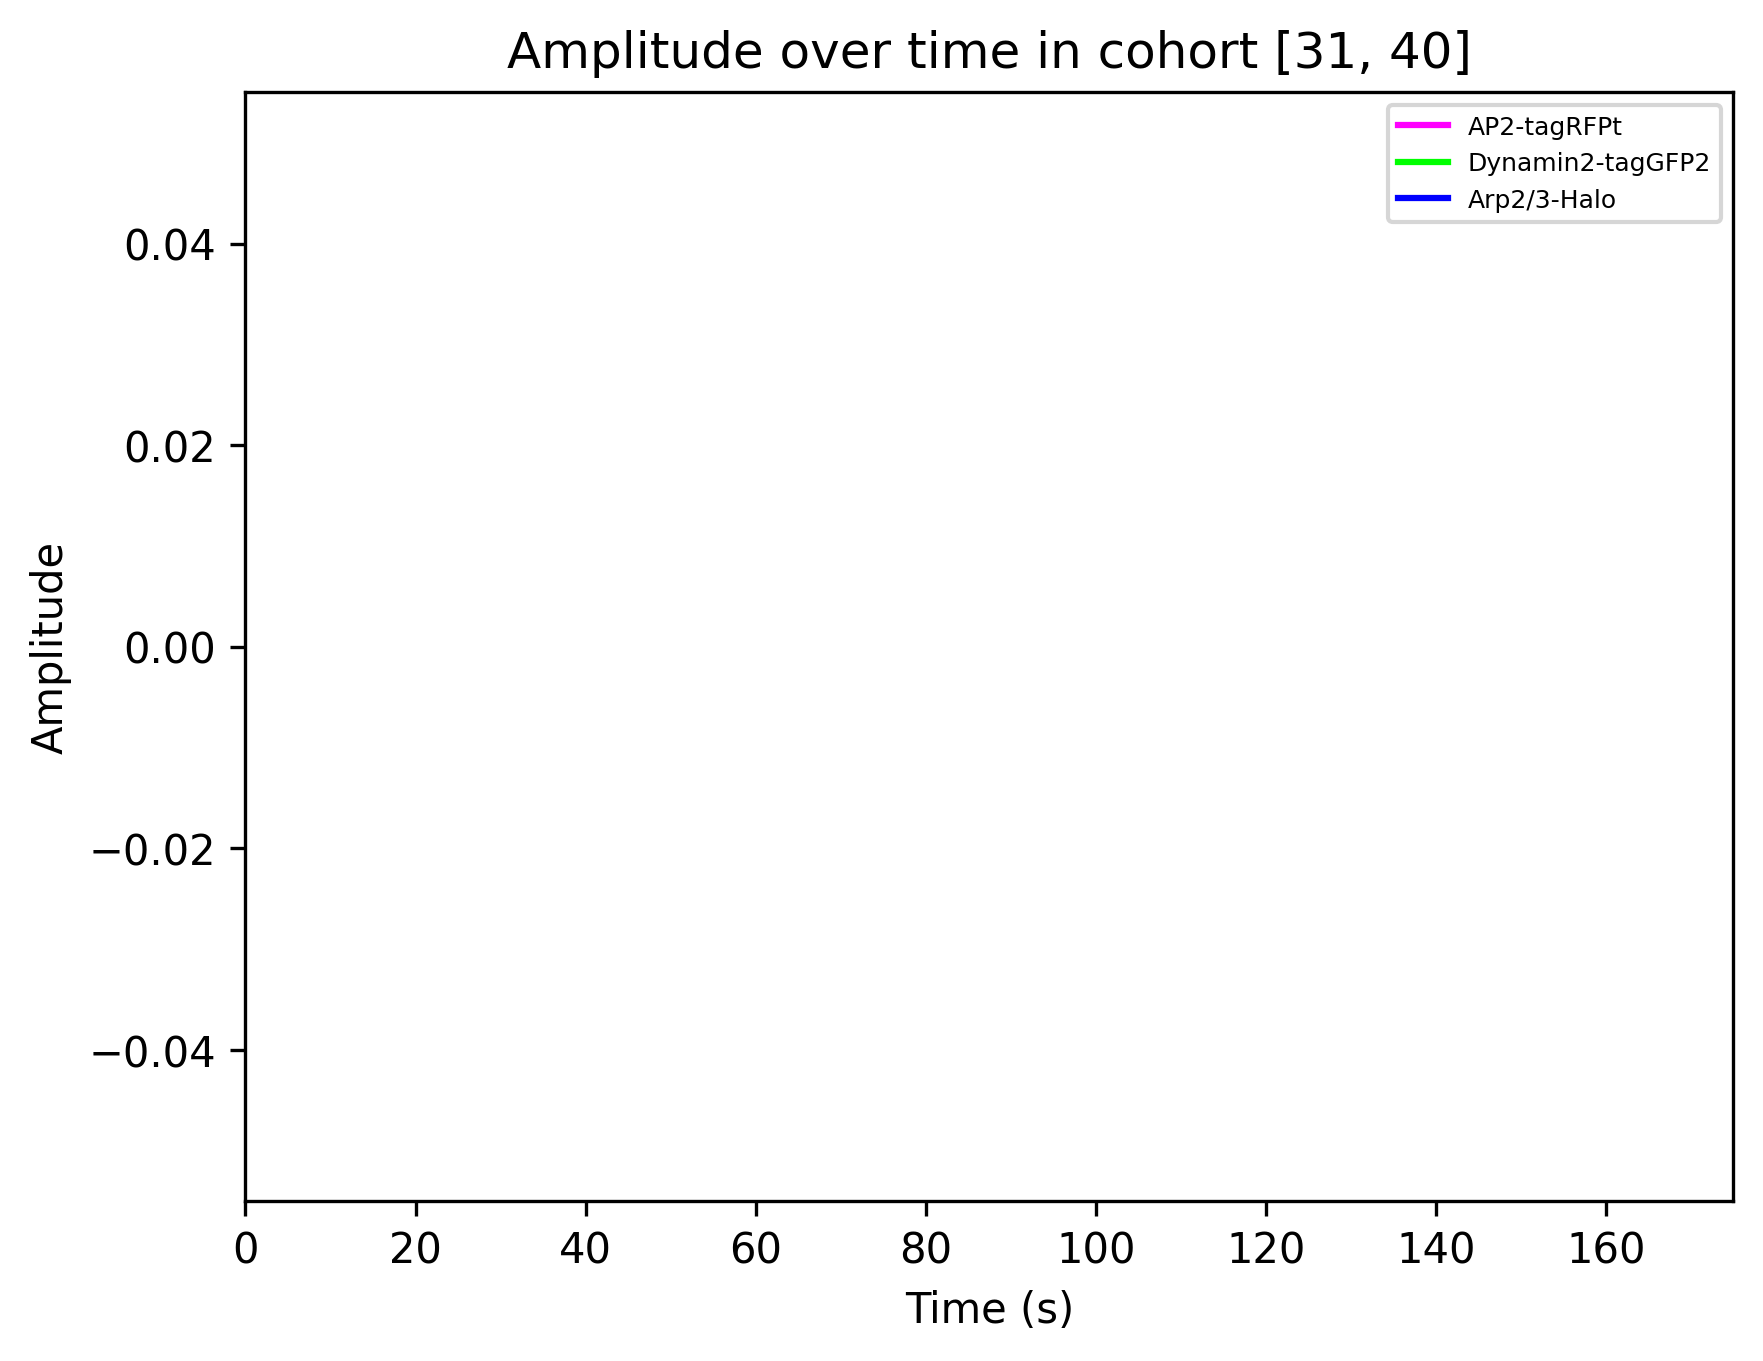

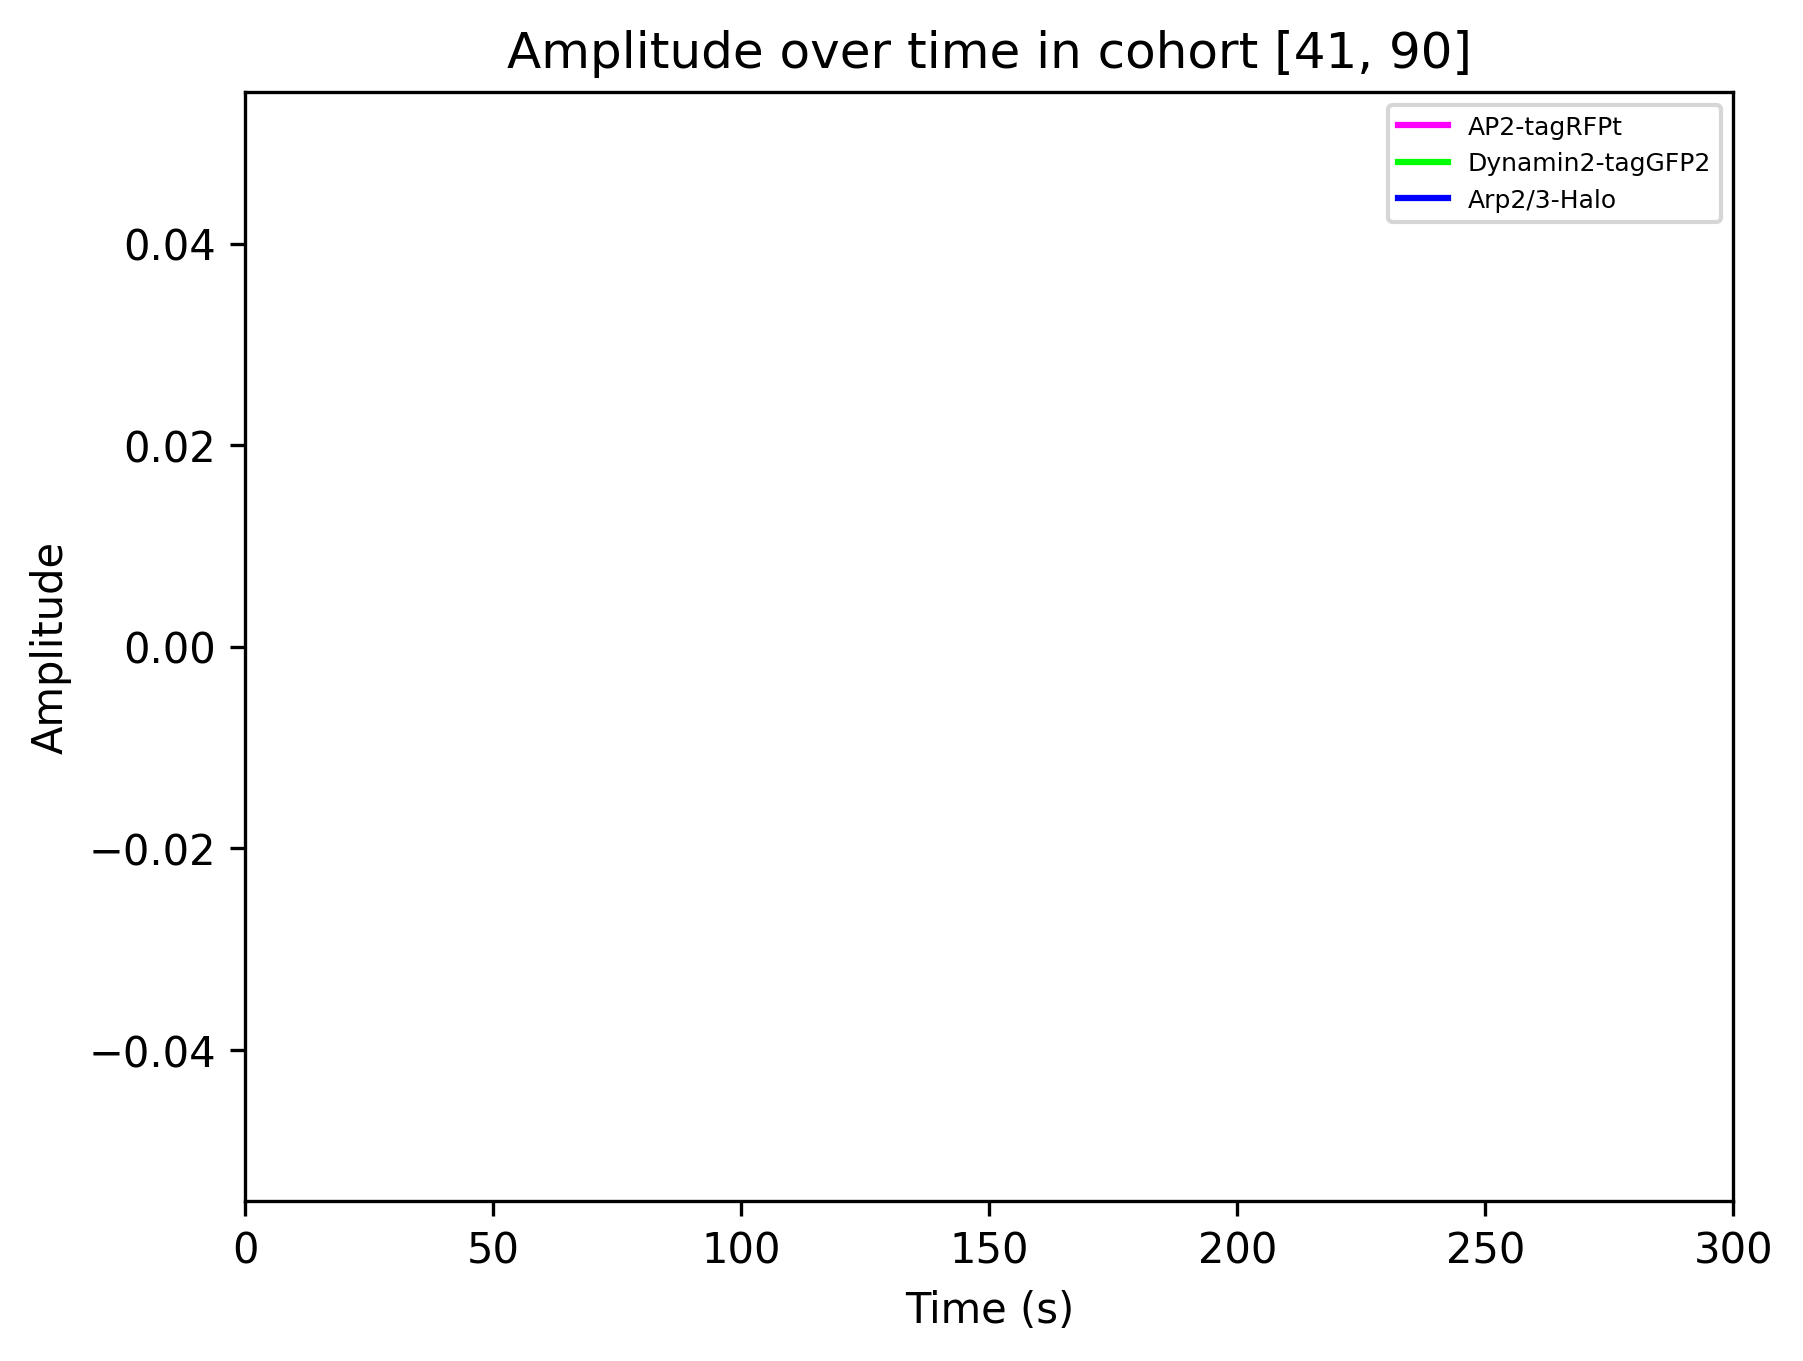

In [35]:
for n, cohort in enumerate(custom_length_ranges):
    primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort(dataframe = track_df ,
    listOfTrackIdsAssignedToCohort = track_id_arrays[n], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1],
    intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')

    cumulative_plots(buffers = [primary_buffer, secondary_buffer, tertiary_buffer],
    background_intensity= [background_channel_3, background_channel_2, background_channel_1], time_shift = 50+cohort[1], framerate_msec = framerate_msec, colors = ['magenta', 'lime', 'blue'], 
                    legend_vals = [channel3_name, channel2_name, channel1_name])
    plt.xlim(0, 75+cohort[1]*framerate_msec/1000)

    plt.title(f'Amplitude over time in cohort {custom_length_ranges[n]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')


Normalized

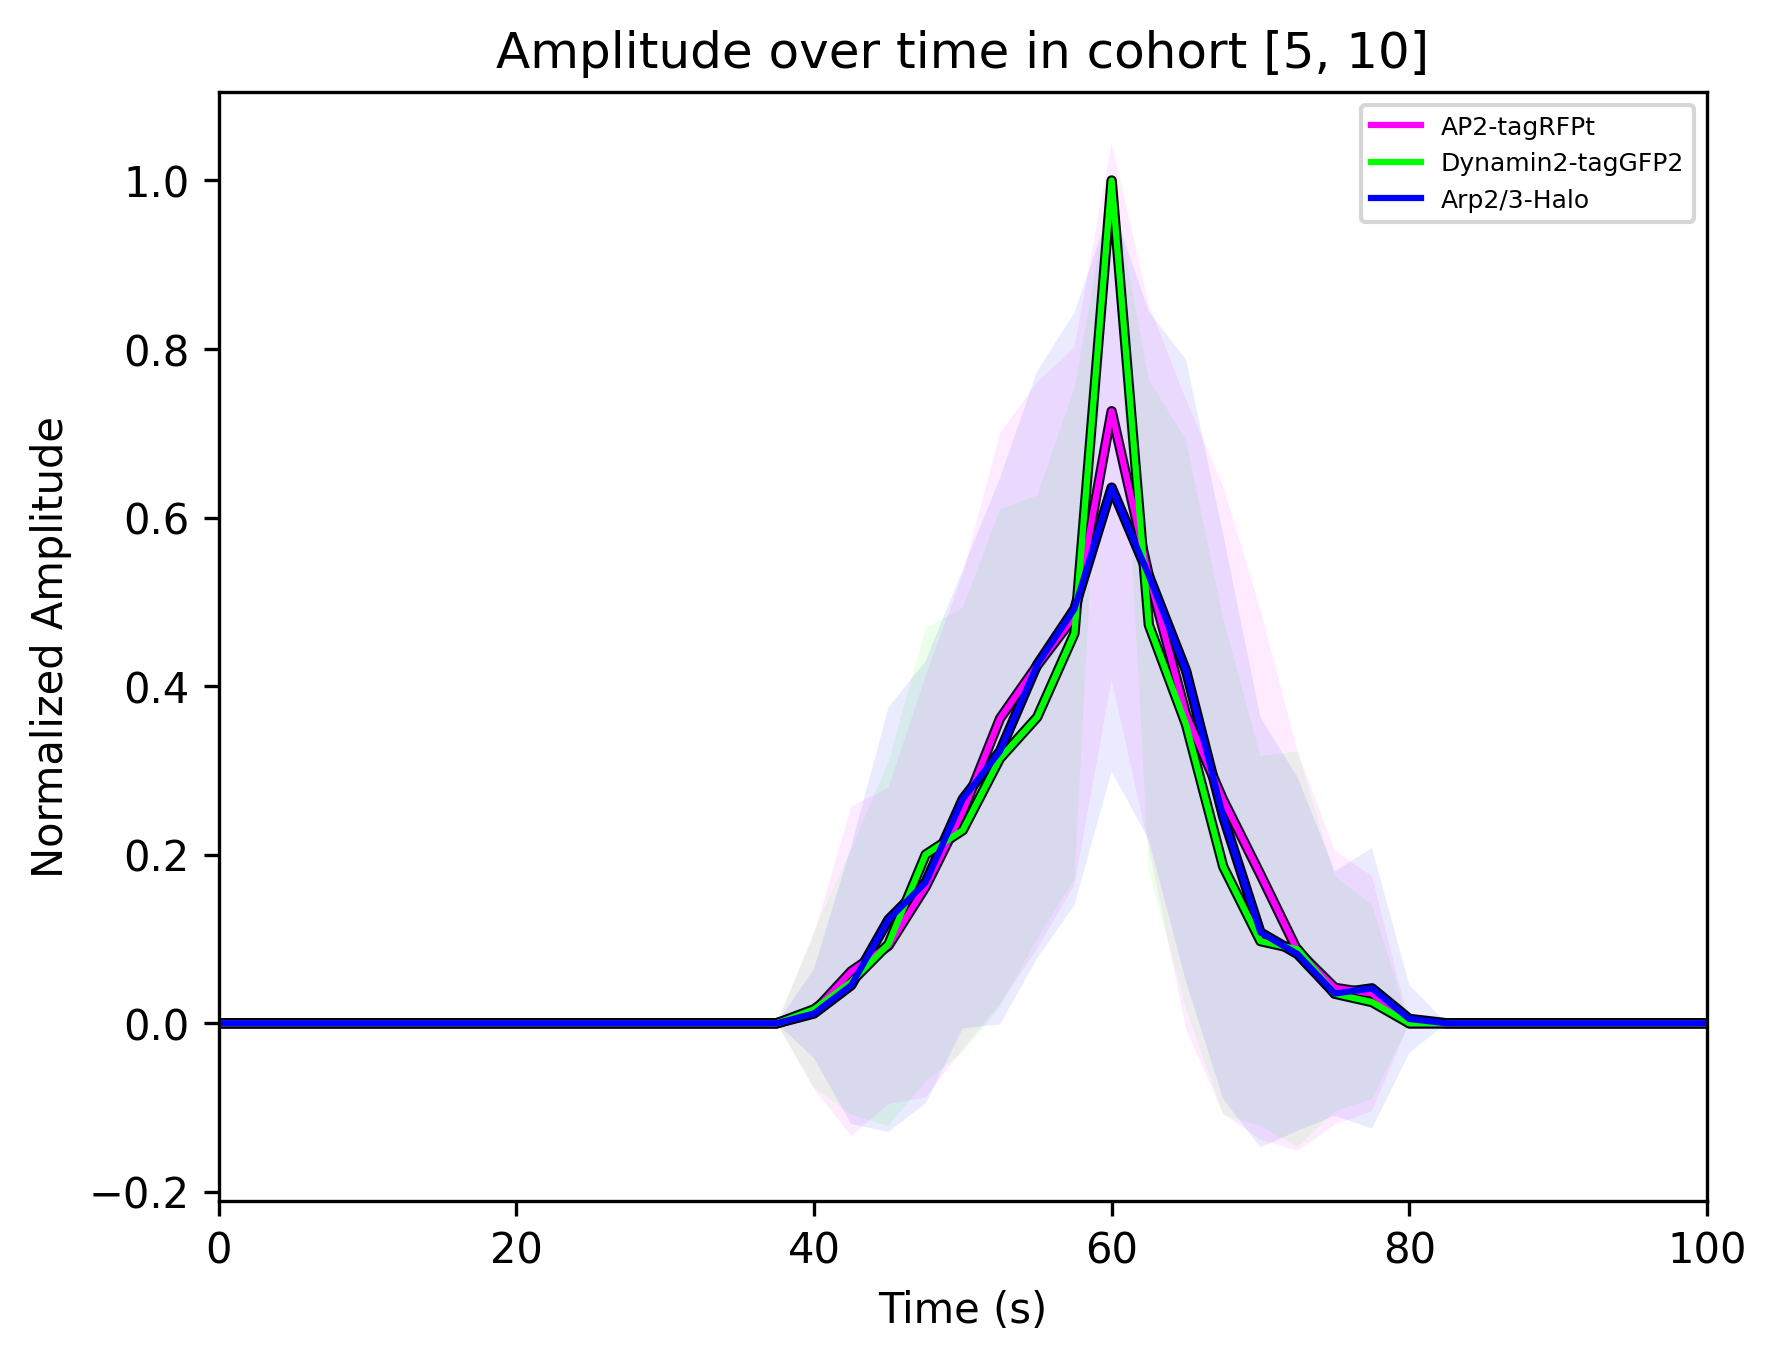

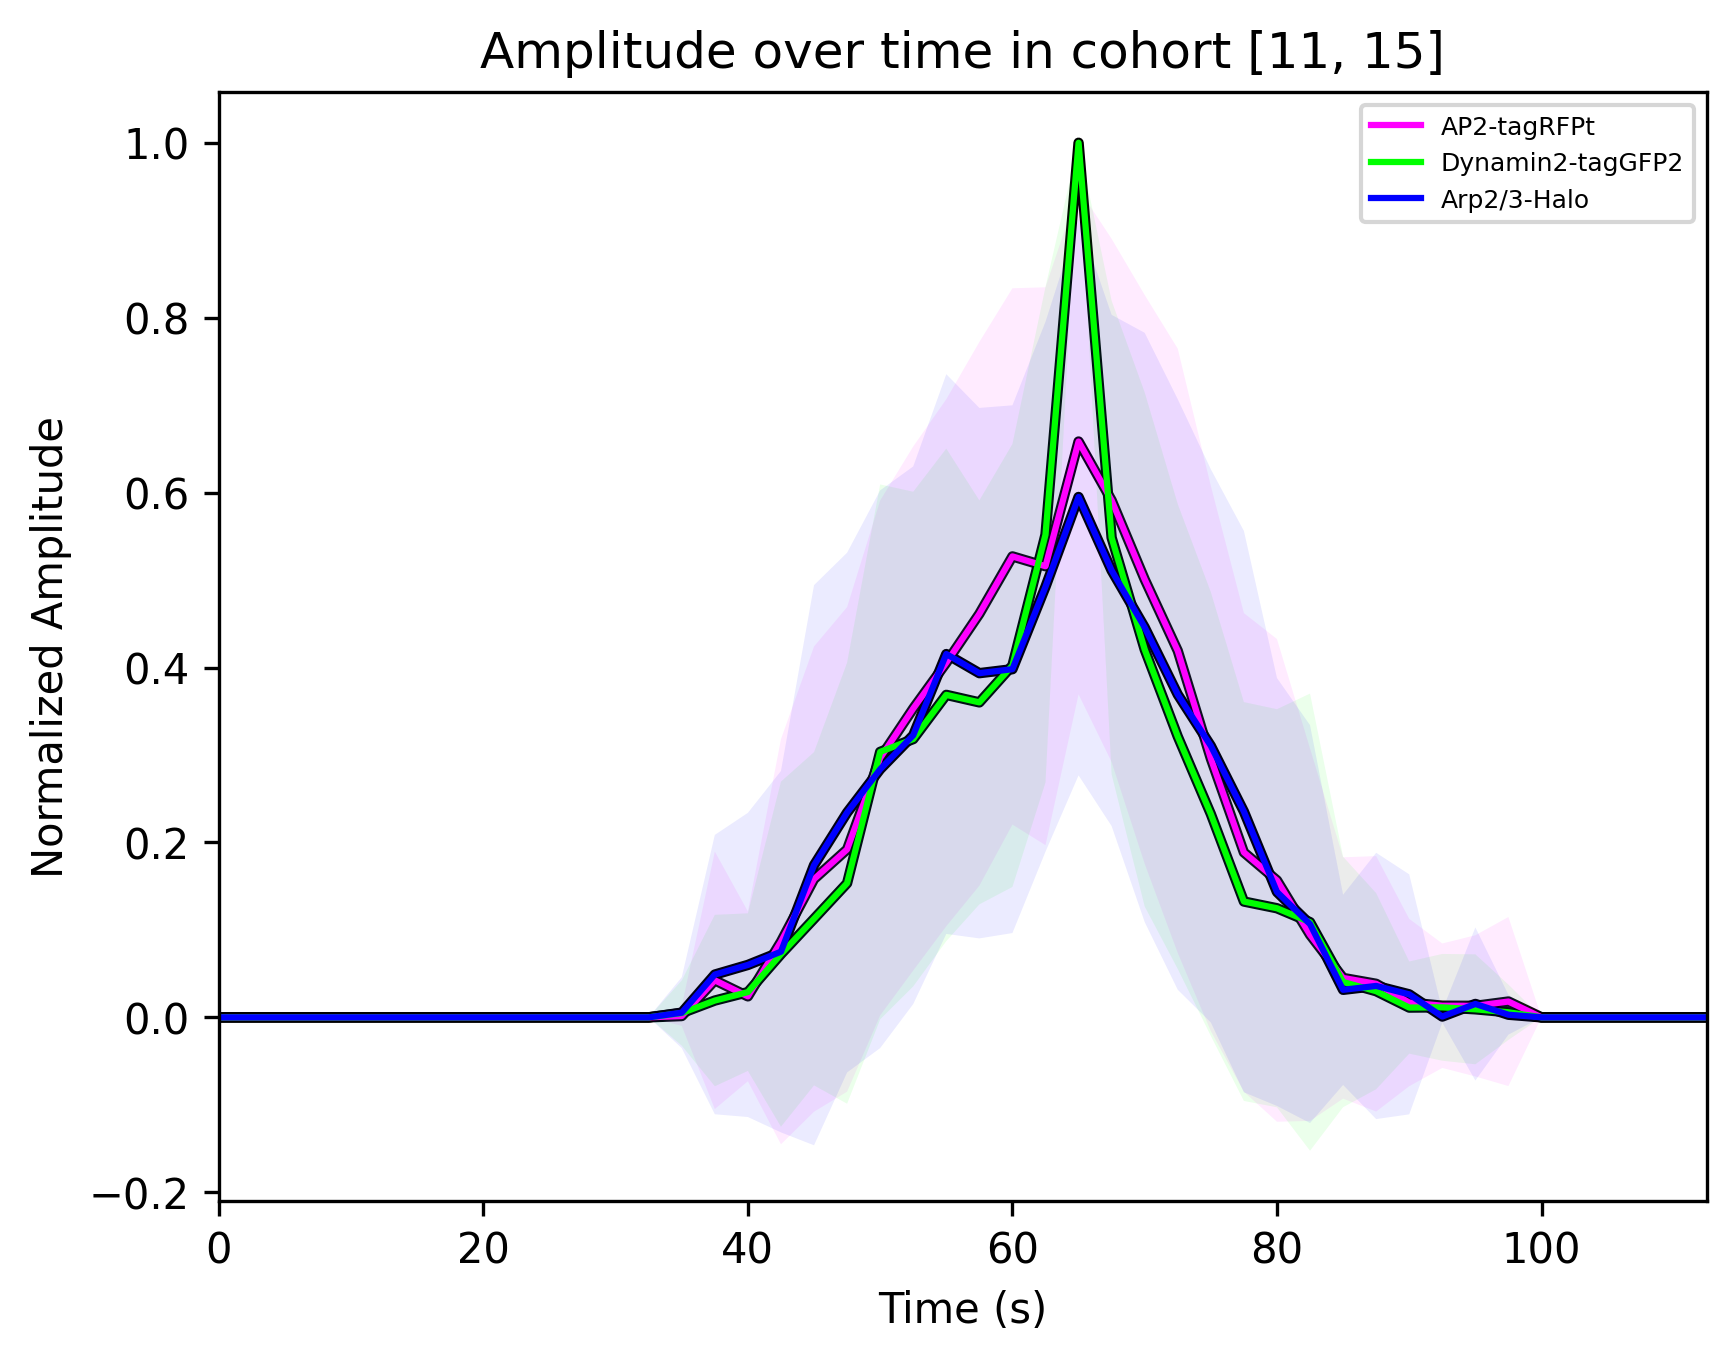

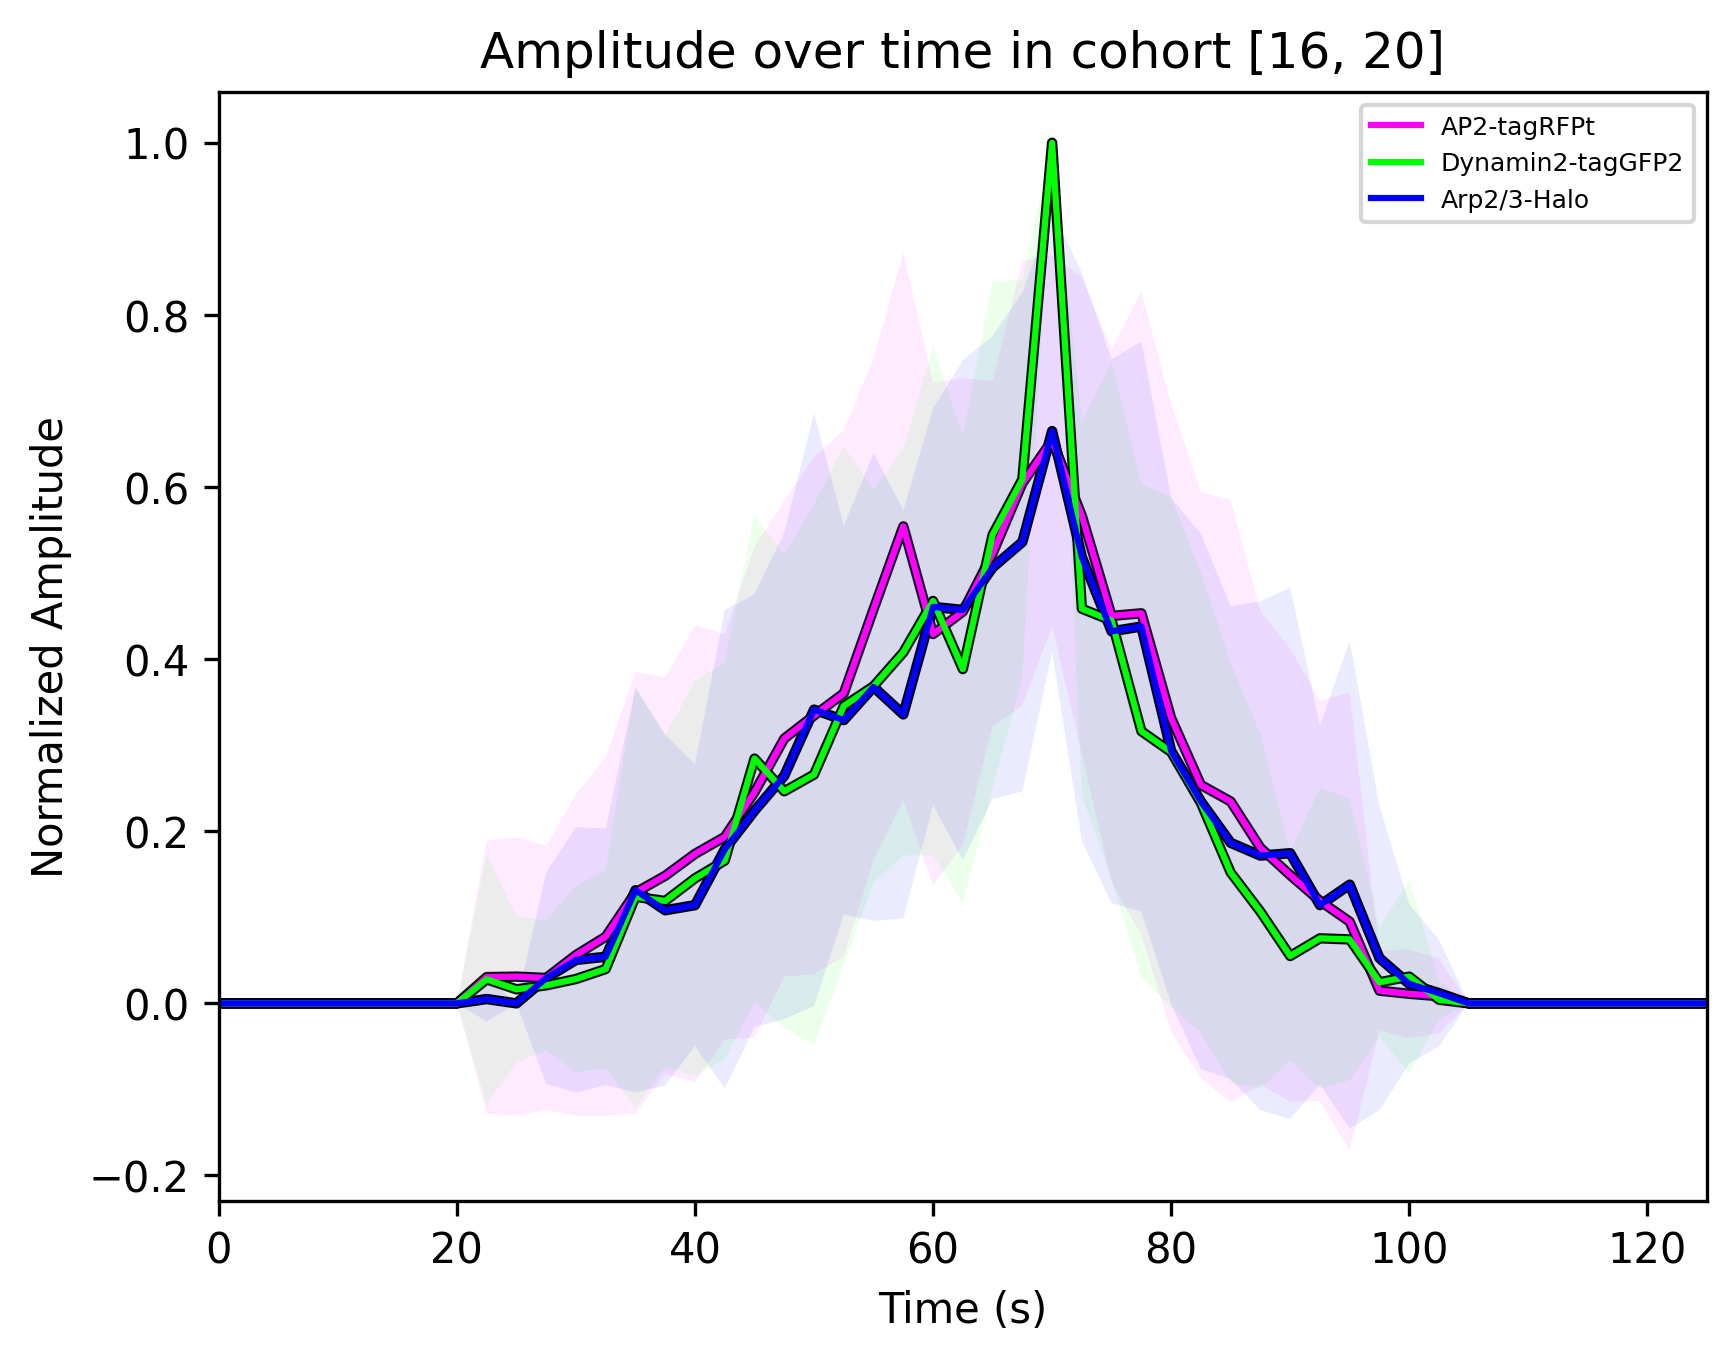

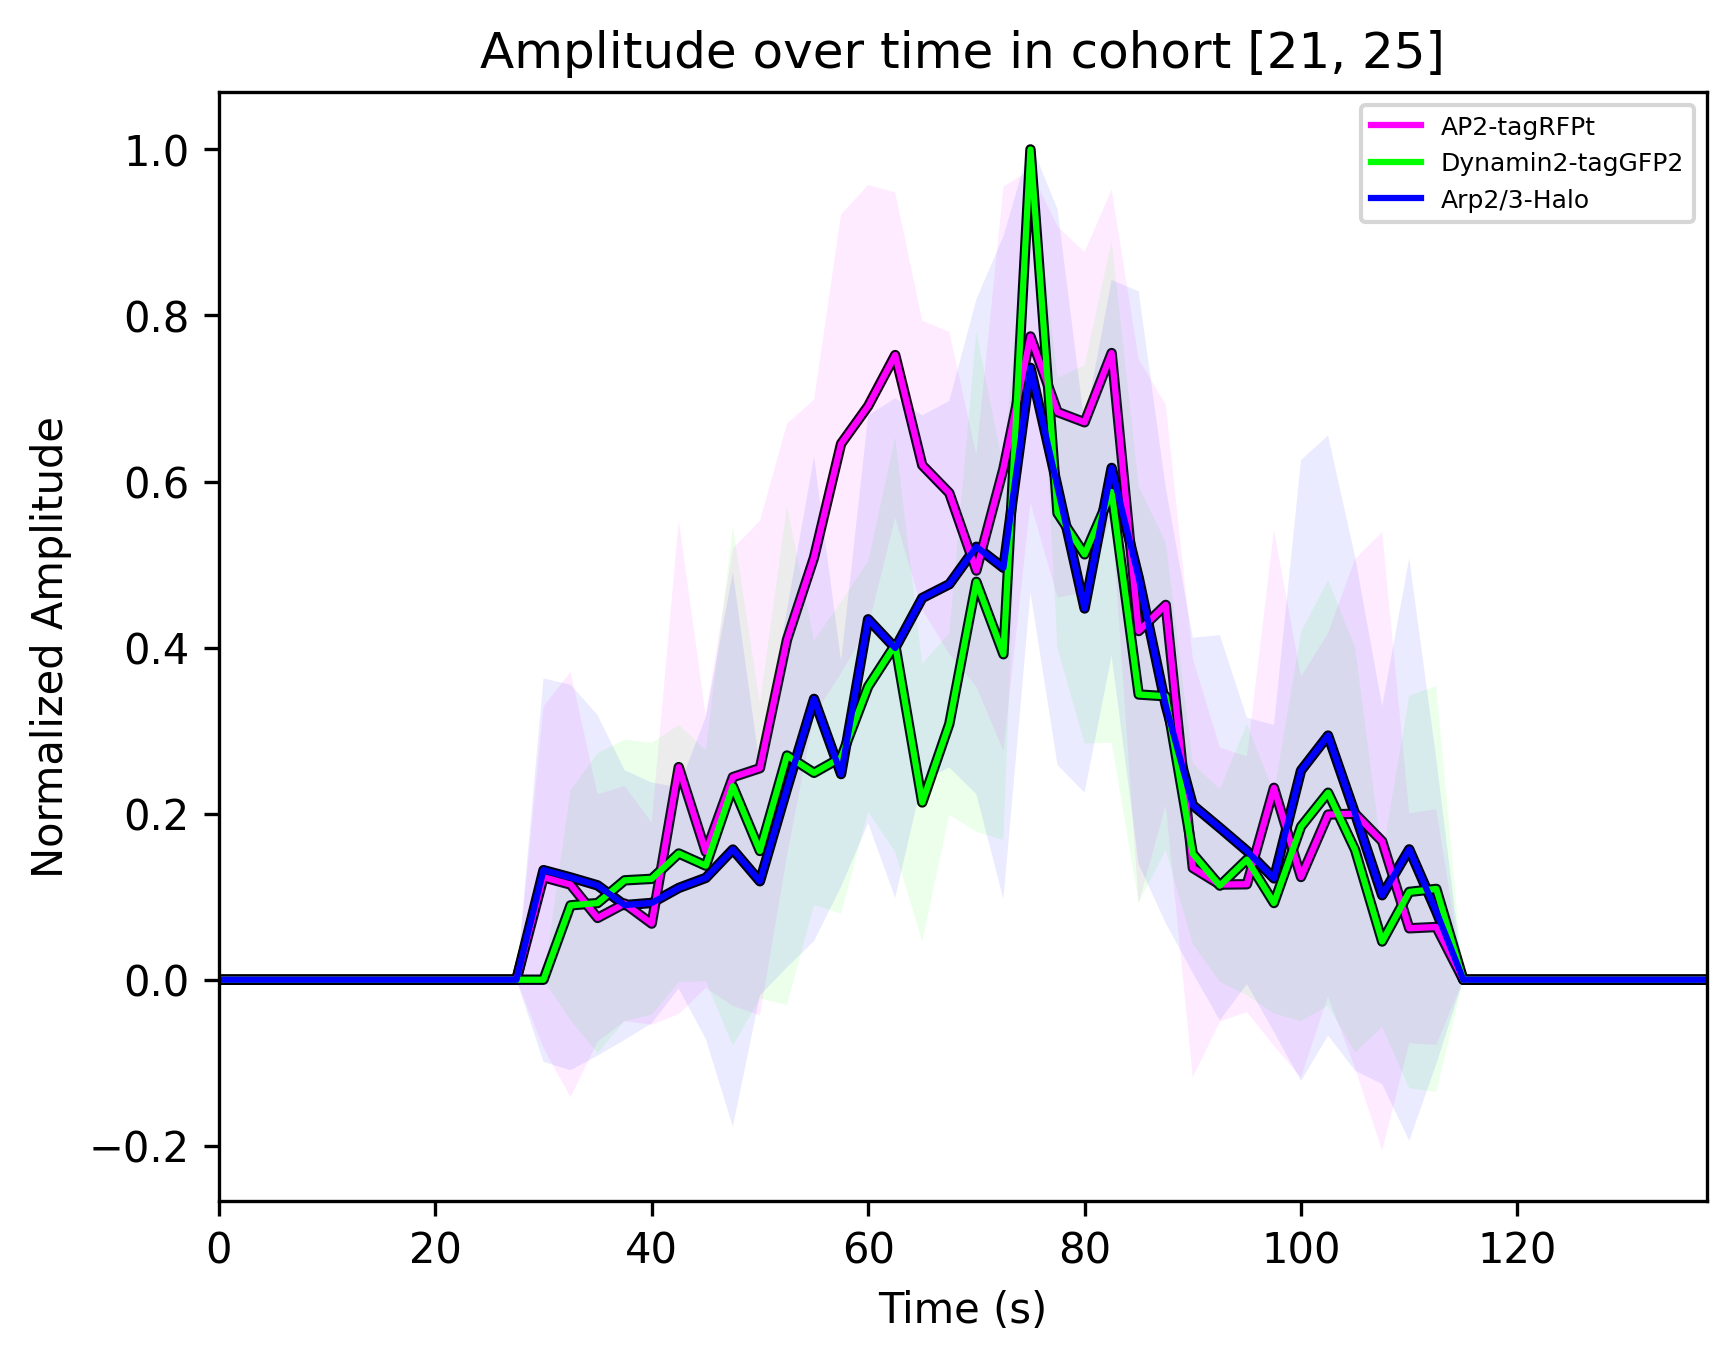

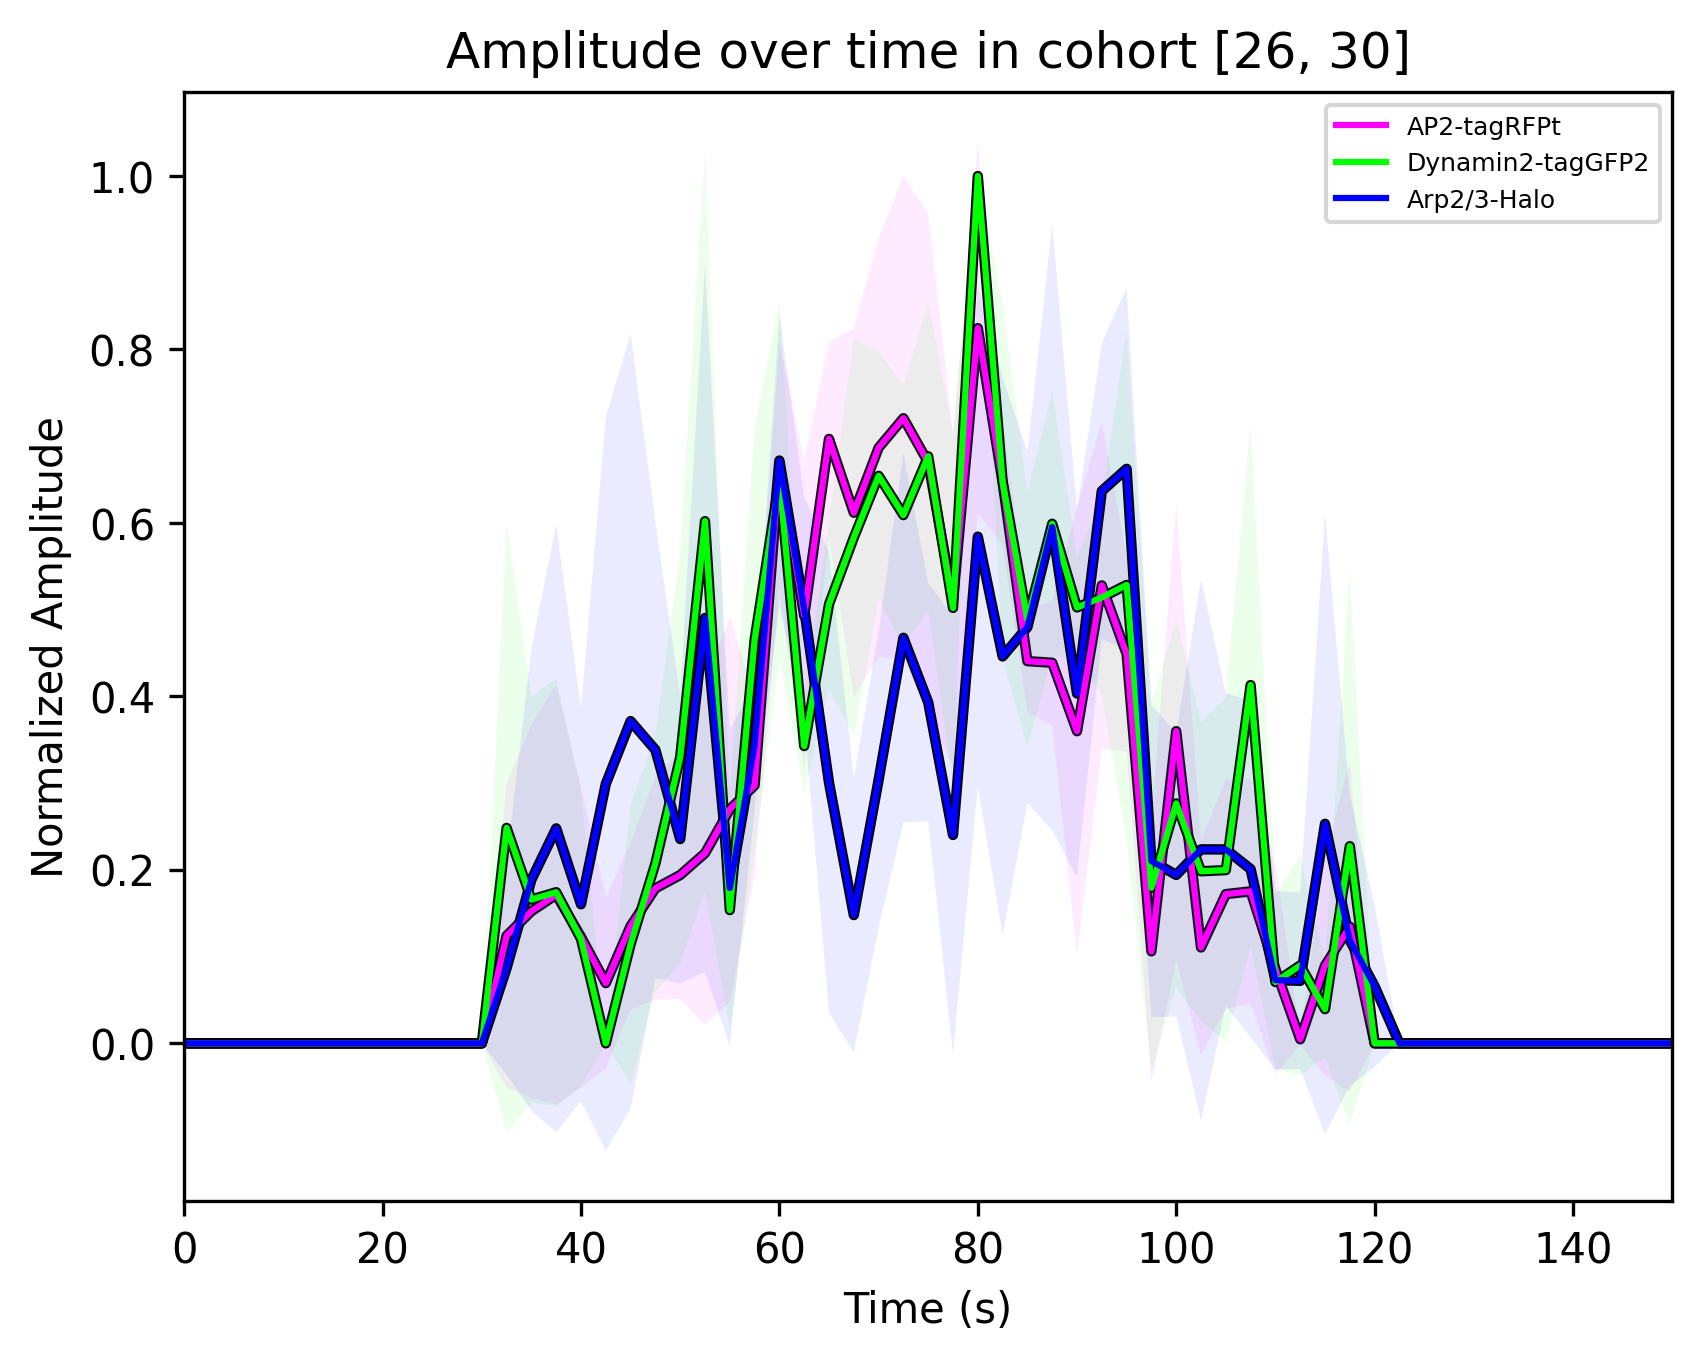

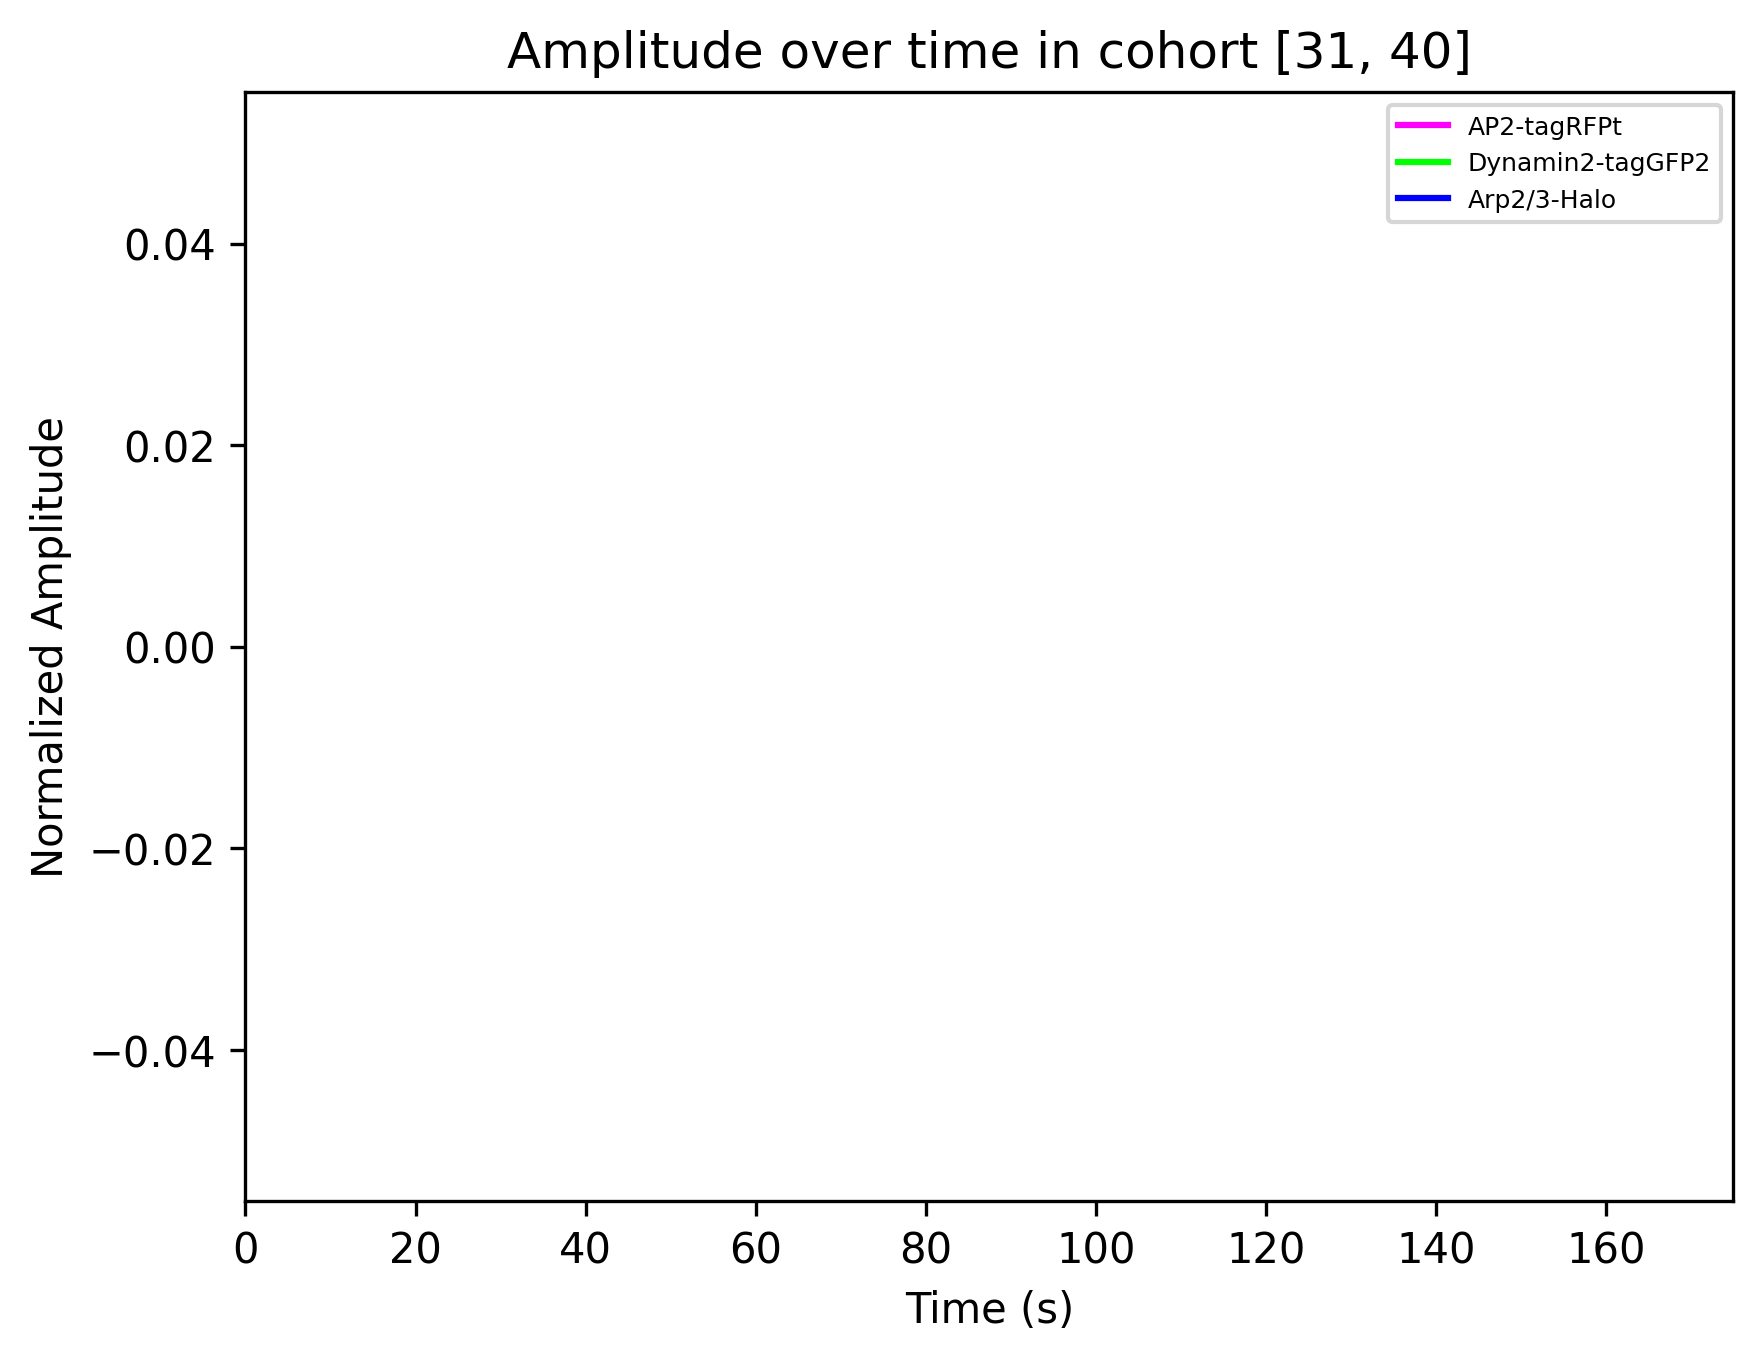

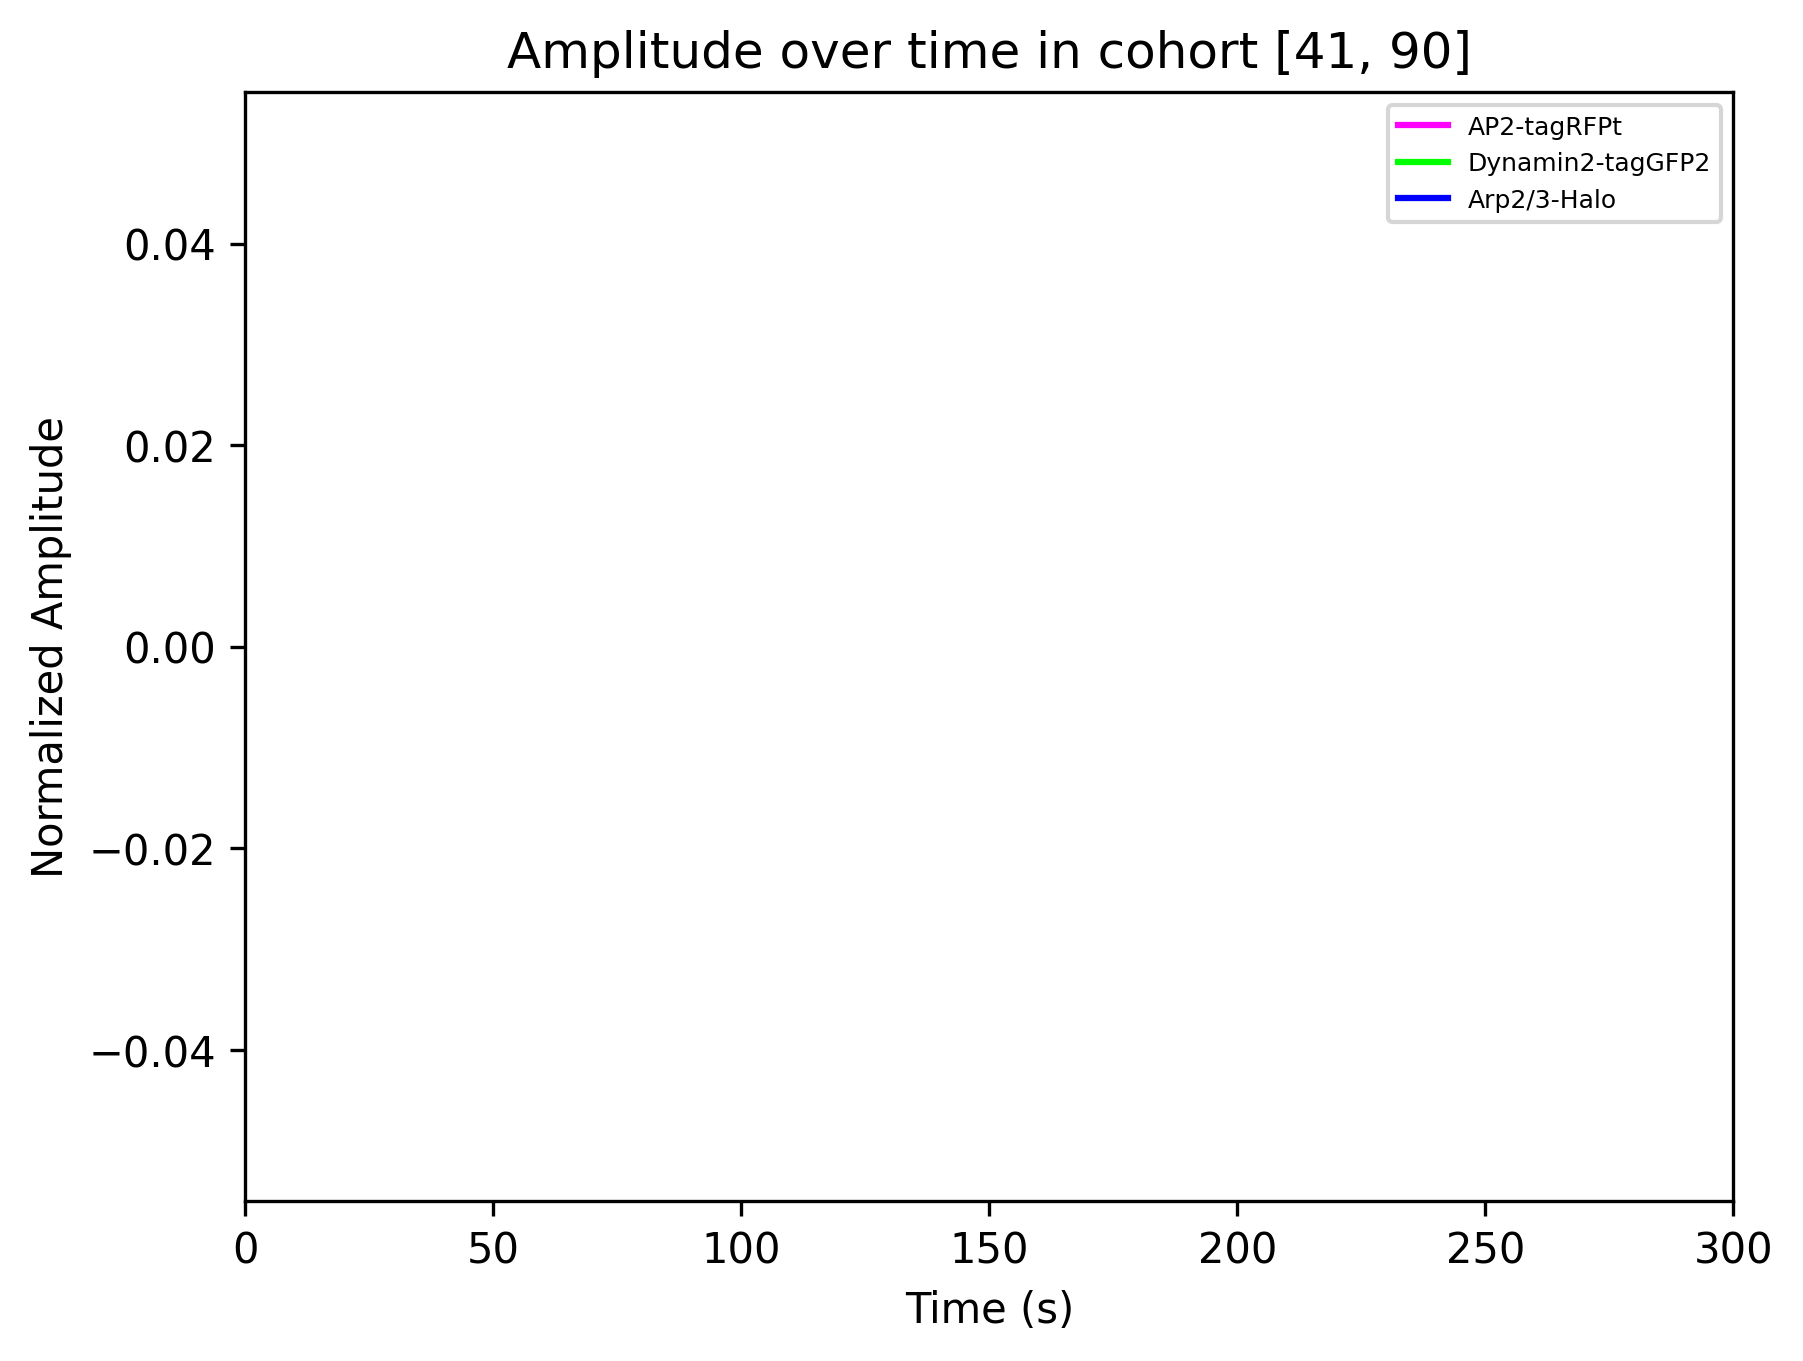

In [36]:
for n, cohort in enumerate(custom_length_ranges):
    primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort_normalized(dataframe = track_df ,
    listOfTrackIdsAssignedToCohort = track_id_arrays[n], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1], 
    intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')
    # intensity_to_plot = ['c3_voxel_sum_adjusted','c2_voxel_sum_adjusted', 'c1_voxel_sum_adjusted'], track_id_col_name = 'track_id')

    cumulative_plots(buffers = [primary_buffer, secondary_buffer, tertiary_buffer],
    background_intensity= [background_channel_3, background_channel_2, background_channel_1], time_shift = 50+cohort[1], framerate_msec = framerate_msec, colors = ['magenta', 'lime', 'blue'], 
                    legend_vals = [channel3_name, channel2_name, channel1_name])
    plt.xlim(0, 75+cohort[1]*framerate_msec/1000)

    plt.title(f'Amplitude over time in cohort {custom_length_ranges[n]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')


In [37]:
# Plot each membrane region separately